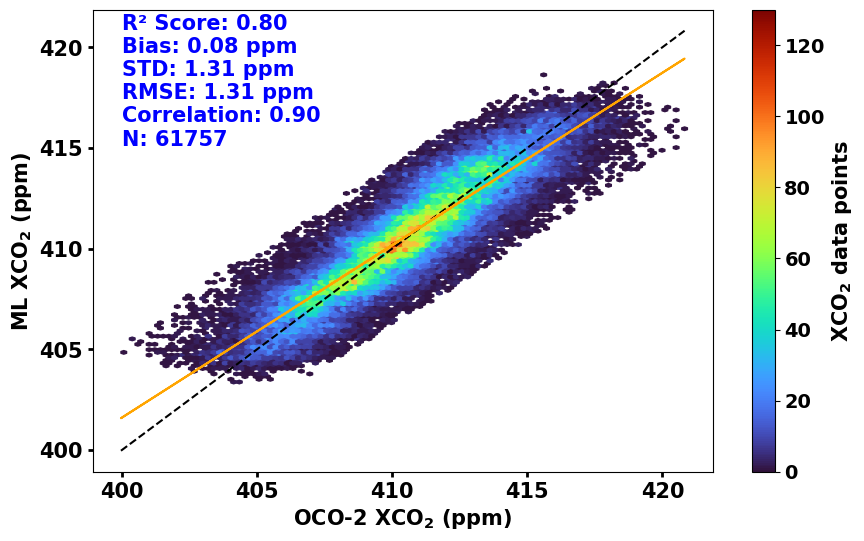

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

data = pd.read_csv(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.csv")

sat_xco2 = data['xco2_adjusted']
ml_xco2 = data['predicted_xco2']
valid_mask = ~sat_xco2.isna()
sat_xco2 = sat_xco2[valid_mask].reset_index(drop=True)
ml_xco2 = ml_xco2[valid_mask].reset_index(drop=True)

X = sat_xco2.values.reshape(-1, 1)
y = ml_xco2.values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)


residuals = y - y_pred
std_res = np.std(residuals)
inlier_mask = np.abs(residuals) < 3 * std_res


sat_xco2 = sat_xco2[inlier_mask].reset_index(drop=True)
ml_xco2 = ml_xco2[inlier_mask].reset_index(drop=True)

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

r2 = r2_score(sat_xco2, ml_xco2)
bias = np.mean(ml_xco2 - sat_xco2)
std_dev = np.std(ml_xco2 - sat_xco2)
rmse = np.sqrt(mean_squared_error(sat_xco2, ml_xco2))
correlation_coef = np.corrcoef(sat_xco2, ml_xco2)[0, 1]
num_data_points = len(sat_xco2)

plt.figure(figsize=(10, 6))
hb = plt.hexbin(sat_xco2, ml_xco2, gridsize=100, cmap='turbo', mincnt=1, vmin=0, vmax=130)

# Add color bar
cbar = plt.colorbar(hb)
cbar.set_label(f"X{format_co2_label()} data points", fontsize=15, fontweight='bold', color='black')

cbar.ax.yaxis.set_tick_params(labelsize=14)
for label in cbar.ax.get_yticklabels():
    label.set_weight("bold")


plt.plot([sat_xco2.min(), sat_xco2.max()], [sat_xco2.min(), sat_xco2.max()], 'k--')

coefficients = np.polyfit(sat_xco2, ml_xco2, 1)
poly_fit = np.poly1d(coefficients)
plt.plot(sat_xco2, poly_fit(sat_xco2), color='orange')

text_x = sat_xco2.min() + 0.002 * (sat_xco2.max() - sat_xco2.min())
text_y = ml_xco2.min() + 1.2 * (ml_xco2.max() - ml_xco2.min())
plt.text(text_x, text_y, 
         f'R² Score: {r2:.2f}\nBias: {bias:.2f} ppm\nSTD: {std_dev:.2f} ppm\nRMSE: {rmse:.2f} ppm\nCorrelation: {correlation_coef:.2f}\nN: {num_data_points}',
         fontsize=15, verticalalignment='top', horizontalalignment='left', color='blue', fontweight='bold')


ax = plt.gca()
ax.tick_params(axis='both', labelsize=15, width=2)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight("bold")
    label.set_color("black")

plt.xlabel(f'OCO-2 X{format_co2_label()} (ppm)', fontsize=15, fontweight='bold')
plt.ylabel(f'ML X{format_co2_label()} (ppm)', fontsize=15, fontweight='bold')
#plt.title('The Validation Results on the Testing Set (DNN)\n(Year 2018-2020)', fontsize=13, fontweight='bold')

#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\200ep_15thOCT_scatter_dnn.png", dpi=600, bbox_inches='tight')
plt.show()


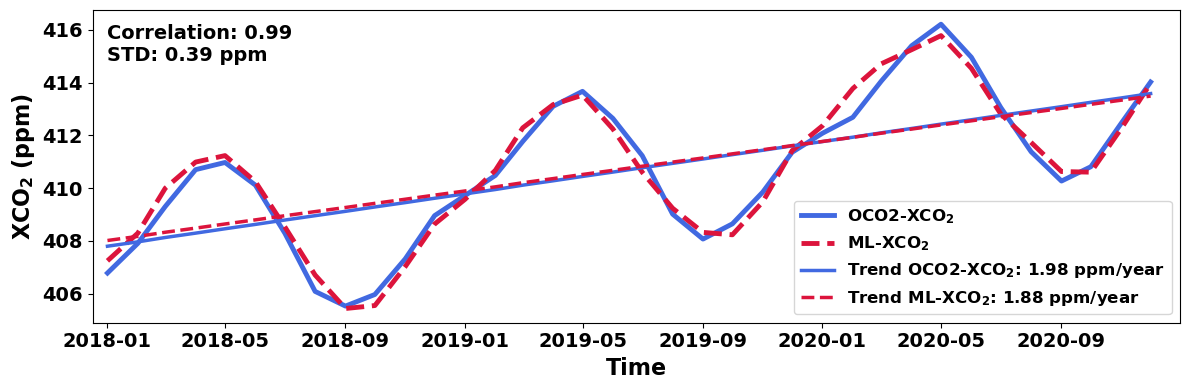

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

data = pd.read_csv(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.csv")

data['time'] = pd.to_datetime(data['time'])

data = data[['time', 'xco2_adjusted', 'predicted_xco2']].dropna()
data = data.rename(columns={'xco2_adjusted': 'xco2'})

residuals = data['predicted_xco2'] - data['xco2']
q1 = residuals.quantile(0.25)
q3 = residuals.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_data = data[(residuals >= lower_bound) & (residuals <= upper_bound)]

monthly_mean = filtered_data.groupby(filtered_data['time'].dt.to_period('M')).agg({
    'xco2': 'mean',
    'predicted_xco2': 'mean'
}).reset_index()

monthly_mean['time'] = monthly_mean['time'].dt.to_timestamp()

monthly_mean = monthly_mean[monthly_mean['time'] <= pd.Timestamp('2020-12-31')]

time_numeric = np.arange(len(monthly_mean))

slope_xco2_month, intercept_xco2, _, _, _ = linregress(time_numeric, monthly_mean['xco2'])
slope_pred_xco2_month, intercept_pred_xco2, _, _, _ = linregress(time_numeric, monthly_mean['predicted_xco2'])

slope_xco2_year = slope_xco2_month * 12
slope_pred_xco2_year = slope_pred_xco2_month * 12

trend_xco2 = intercept_xco2 + slope_xco2_month * time_numeric
trend_pred_xco2 = intercept_pred_xco2 + slope_pred_xco2_month * time_numeric

from scipy.stats import pearsonr


correlation, p_value = pearsonr(monthly_mean['xco2'], monthly_mean['predicted_xco2'])
std_dev = np.std(monthly_mean['predicted_xco2'] - monthly_mean['xco2'])

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

plt.figure(figsize=(12, 4))

plt.plot(
    monthly_mean['time'], 
    monthly_mean['xco2'], 
    label=f'OCO2-X{format_co2_label()}', 
    color='royalblue', linestyle='-', linewidth=3.5
)

plt.plot(
    monthly_mean['time'], 
    monthly_mean['predicted_xco2'], 
    label=f'ML-X{format_co2_label()}', 
    color='crimson', linestyle='--', linewidth=3.5
)

plt.plot(
    monthly_mean['time'], 
    trend_xco2, 
    label=f'Trend OCO2-X{format_co2_label()}: {slope_xco2_year:.2f} ppm/year', 
    color='royalblue', linestyle='-', linewidth=2.5
)
plt.plot(
    monthly_mean['time'], 
    trend_pred_xco2, 
    label=f'Trend ML-X{format_co2_label()}: {slope_pred_xco2_year:.2f} ppm/year', 
    color='crimson', linestyle='--', linewidth=2.5
)

plt.xlabel('Time', fontsize=16, fontweight='bold')
plt.ylabel(f'X{format_co2_label()} (ppm)', fontsize=16, fontweight='bold')

text_x = monthly_mean['time'].min()
text_y = max(monthly_mean['xco2'].max(), monthly_mean['predicted_xco2'].max())
plt.text(text_x, text_y, 
         f'Correlation: {correlation:.2f} \nSTD: {std_dev:.2f} ppm', 
         fontsize=14, 
         fontweight='bold', 
         color='black', 
         verticalalignment='top')

plt.tick_params(axis='both', labelsize=14)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

legend = plt.legend(loc='lower right', fontsize=12, frameon=True)
for text in legend.get_texts():
    text.set_fontweight('bold')
import matplotlib.dates as mdates
from pandas.tseries.offsets import Day

ax = plt.gca()

start_time = monthly_mean['time'].min() - Day(15)
end_time   = pd.Timestamp('2020-12-31')
ax.set_xlim(start_time, end_time)

ax.xaxis.set_major_locator(
    mdates.MonthLocator(bymonth=[1, 5, 9]) 
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
#plt.savefig(r"D:\24thJAN_DNN_MTech\other200ep_24thJAN_timeseries_2018_20_ML_oco2.png", dpi=600, bbox_inches='tight')
plt.show()


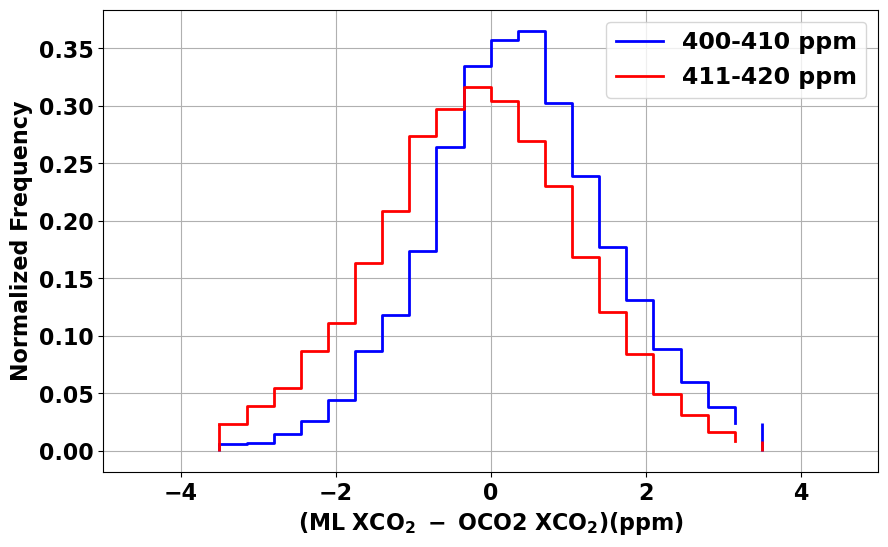

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.csv")


data['time'] = pd.to_datetime(data['time'])

data = data[['time', 'xco2_adjusted', 'predicted_xco2']].dropna()
data = data.rename(columns={'xco2_adjusted': 'xco2'})


residuals = data['predicted_xco2'] - data['xco2']
q1 = residuals.quantile(0.25)
q3 = residuals.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_data = data[(residuals >= lower_bound) & (residuals <= upper_bound)]

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 
def histogram_of_biases_by_range(data):
    plt.figure(figsize=(10, 6))
    
    
    ranges = [(400, 410), (411, 420)]
    colors = ['blue', 'red']
    legend_handles = []

    
    bins = np.linspace(-3.5, 3.5, 21)  

    for (low, high), color in zip(ranges, colors):
        subset = data[(data['xco2'] >= low) & (data['xco2'] < high)]
        
        if subset.empty:
            print(f"No data found in range {low}-{high} ppm")
            continue
        
        biases = subset['predicted_xco2'] - subset['xco2']
        
        
        counts, bin_edges = np.histogram(biases, bins=bins, density=True)
        
        line, = plt.plot(bin_edges[:-1], counts, drawstyle='steps-post', color=color, linewidth=2, label=f'{low}-{high} ppm')
        legend_handles.append(line)

        
        plt.vlines(bin_edges[0], 0, counts[0], color=color, linewidth=2)
        plt.vlines(bin_edges[-1], 0, counts[-1], color=color, linewidth=2)
    
    
    #plt.xlabel(r'$\mathrm{(ML\ XCO_2\ -\ OCO2\ XCO_2)}\ (\mathrm{ppm})$', fontsize=12, fontweight='bold')
    plt.xlabel(r'$\mathbf{(ML\ XCO_2\ -\ OCO2\ XCO_2) (ppm)}\ \mathrm{}$', fontsize=16, fontweight='bold', color='black')

    #plt.xlabel(f'(ML X{format_co2_label()} - OCO2 X{format_co2_label()}) (ppm)', fontsize=12, fontweight='bold')
    plt.ylabel('Normalized Frequency', fontsize=16, fontweight='bold')
    #plt.title(f'Error Histogram for Different X{format_co2_label()} Ranges\n(DNN Model | 2018–2020)', fontsize=13, fontweight='bold')
    
    
    plt.legend(handles=legend_handles, loc='upper right', prop={'weight': 'bold', 'size': 17})

    plt.tick_params(axis='both', which='major', labelsize=16)

    ax = plt.gca()
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.xlim([-5, 5])  
    plt.grid(True)
    #plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\200ep15thOCT_diff_range_histograms_plot.png", dpi=600, bbox_inches='tight')
    plt.show()



histogram_of_biases_by_range(data)


In [4]:
import xarray as xr
ds7 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")
xco2 = ds7["xco2_adjusted"].sel(latitude=slice(6, 38), longitude=slice(66, 100), time=slice("2003-01-01", "2020-12-01"))
predicted_xco2 = ds7["predicted_xco2"]


valid_mask = ~np.isnan(xco2)


xco2_valid = xco2.where(valid_mask, drop=True)
predicted_xco2_valid = predicted_xco2.where(valid_mask, drop=True)

window_size = 2  

correlations = []
biases = []
stds = []

for i in range(len(xco2_valid.time)):
    
    start = max(0, i - window_size // 2)
    end = min(len(xco2_valid.time), i + window_size // 2 + 1)
    
    
    xco2_window = xco2_valid.isel(time=slice(start, end))
    predicted_window = predicted_xco2_valid.isel(time=slice(start, end))
    
    
    xco2_stacked = xco2_window.stack(points=("time", "latitude", "longitude"))
    predicted_stacked = predicted_window.stack(points=("time", "latitude", "longitude"))
    
    
    valid_mask = (~np.isnan(xco2_stacked)) & (~np.isnan(predicted_stacked))
    xco2_stacked = xco2_stacked.where(valid_mask, drop=True)
    predicted_stacked = predicted_stacked.where(valid_mask, drop=True)
    
    if xco2_stacked.size > 0 and predicted_stacked.size > 0:
        # Correlation
        corr = xr.corr(xco2_stacked, predicted_stacked, dim="points").item()
        
        # Bias
        bias = (predicted_stacked - xco2_stacked).mean(dim="points").item()
        
        # STD 
        std = xco2_stacked.std(dim="points").item()
        
    else:
        corr = np.nan
        bias = np.nan
        std = np.nan
    
    correlations.append(corr)
    biases.append(bias)
    stds.append(std)


correlation_series = xr.DataArray(correlations, coords=[xco2_valid.time], dims="time")
bias_series = xr.DataArray(biases, coords=[xco2_valid.time], dims="time")
std_series = xr.DataArray(stds, coords=[xco2_valid.time], dims="time")


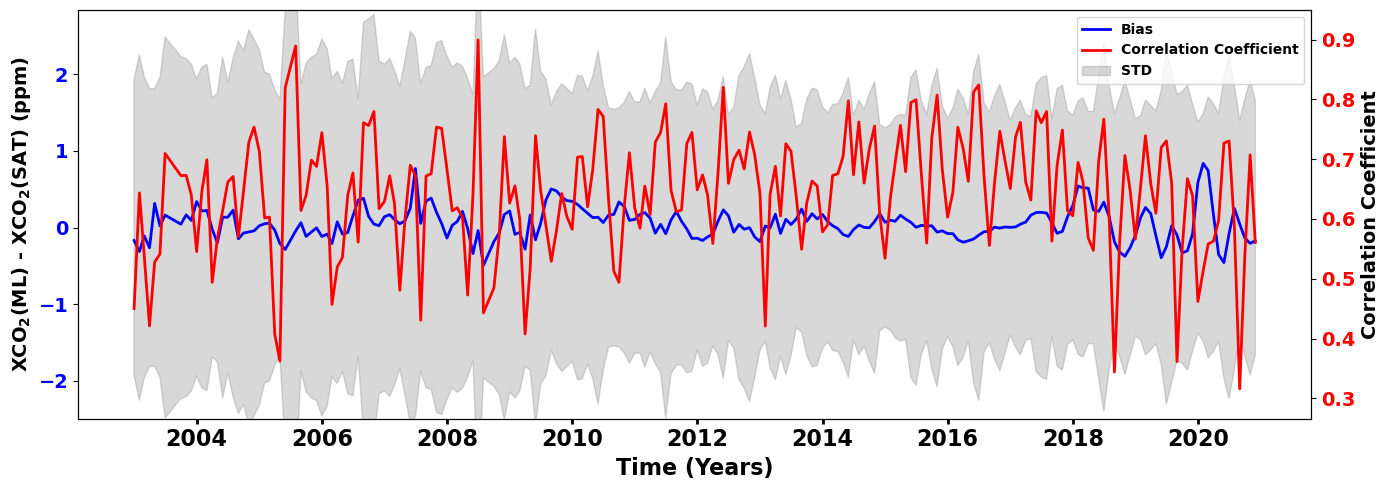

In [5]:
# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))  


line1, = ax1.plot(xco2_valid.time, bias_series, color='blue', label="Bias", linewidth=2)

ax1.set_ylabel(f"X{format_co2_label()}(ML) - X{format_co2_label()}(SAT) (ppm)", fontsize=14, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='blue')

for label in ax1.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontweight('bold')
    label.set_color('blue')


bias_max = bias_series.max().item()  
ax1.set_ylim(bias_series.min() - 2, max(bias_max + 2, 0.6))  

ax2 = ax1.twinx()
line2, = ax2.plot(xco2_valid.time, correlation_series, color='red', label="Correlation Coefficient", linewidth=2)
ax2.set_ylabel("Correlation Coefficient", fontsize=14, fontweight='bold', color='black')
ax2.tick_params(axis='y', labelcolor='red')

for label in ax2.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontweight('bold')
    label.set_color('red')


ax2.set_ylim(correlation_series.min() - 0.05, correlation_series.max() + 0.05)


fill_std = ax1.fill_between(xco2_valid.time, -std_series, std_series, color='gray', alpha=0.3, label="±1 STD")


ax1.set_xlabel("Time (Years)", fontsize=16, fontweight='bold', color='black')


ax1.tick_params(axis='x', labelsize=16, labelcolor='black', width=2)
for label in ax1.get_xticklabels():
    label.set_fontweight('bold')
    label.set_color('black')


#plt.title("Validating The ML Results with Satellite Data (Year 2003-2020)", fontsize=14, fontweight='bold', color='black')
ax1.legend([line1, line2, fill_std], ["Bias", "Correlation Coefficient", "STD"], 
           loc="upper right", fontsize=10, frameon=True, prop={'weight': 'bold'})




plt.tight_layout()
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_validating_ML_sat_xco2_2003_2020.png", dpi=600, bbox_inches='tight')


plt.show()


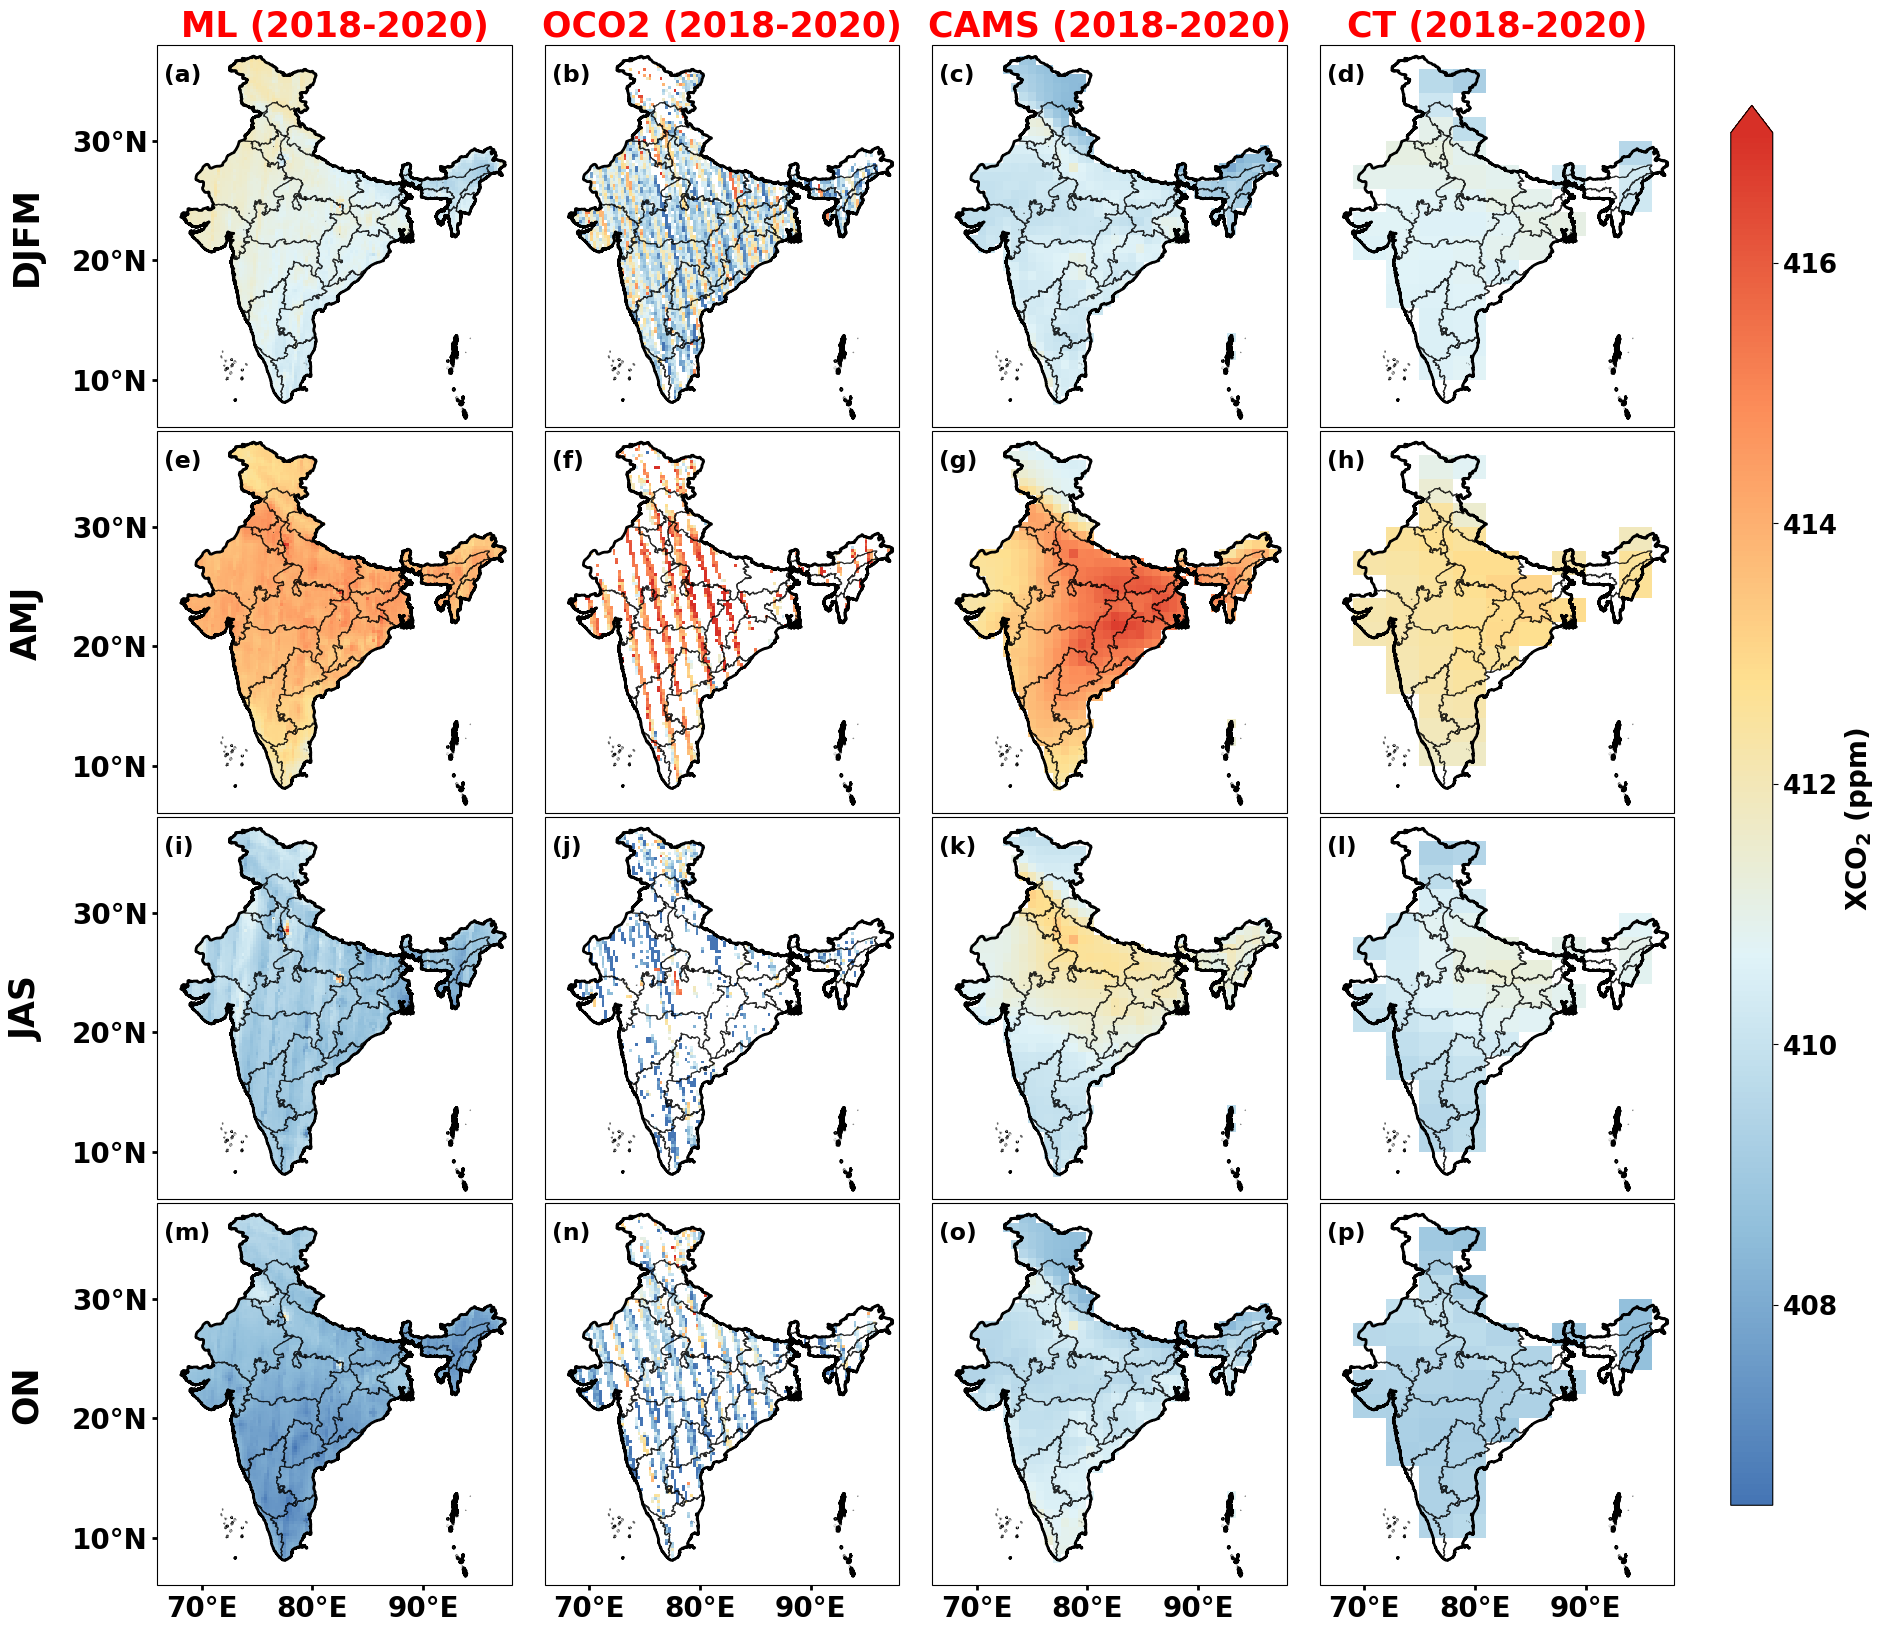

In [6]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter


india_shapefile = r'C:\Users\digvi\India_Boundary.shp'
district_shapefile = r'D:\project_revived_march_25\india_state\Indian_States.shp'
india_boundary = gpd.read_file(india_shapefile).to_crs(epsg=4326)
district_boundaries = gpd.read_file(district_shapefile).to_crs(epsg=4326)


ds = xr.open_dataset(r"D:\project_revived_march_25\OCO2_new\11thOCT_oco2_gridded_xco2_xco2adj_0.25deg.nc")
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.nc")
ds2 = xr.open_dataset(r"D:\CAMS_3H_MONTHLY_2003_2020\new_CAM_Monthly_2003_2020_075reso_updated_time.nc")
ds3 = xr.open_dataset(r"D:\CT_monthly_files\new_merged_CT_xco2_2003_2020.nc")


ds = ds.sel(time=slice("2018-01-01", "2020-12-01"))
ds1 = ds1.sel(time=slice("2018-01-01", "2020-12-01"))
ds2 = ds2.sel(time=slice("2018-01-01", "2020-12-01"))
ds3 = ds3.sel(time=slice("2018-01-01", "2020-12-01"))


ds = ds.assign_coords(month=ds["time"].dt.month)
ds1 = ds1.assign_coords(month=ds1["time"].dt.month)
ds2 = ds2.assign_coords(month=ds2["time"].dt.month)
ds3 = ds3.assign_coords(month=ds3["time"].dt.month)
colors = [
    "#4575b4", 
    "#91bfdb", 
    "#e0f3f8", 
    "#fee090", 
    "#fc8d59", 
    "#d73027"  
]
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(
    "xco2_hexcolormap",
    colors,
    N=256   
)

seasons = {"DJFM": [12, 1, 2, 3], "AMJ": [4, 5, 6],
           "JAS": [7, 8, 9], "ON": [10, 11]}

seasonal_avg_satco2 = {s: ds["xco2_adjusted"].where(ds.month.isin(m)).mean(dim="time") for s, m in seasons.items()}
seasonal_avg_xco2 = {s: ds1["predicted_xco2"].where(ds1.month.isin(m)).mean(dim="time") for s, m in seasons.items()}
seasonal_avg_tcco2 = {s: ds2["tcco2"].where(ds2.month.isin(m)).mean(dim="time") for s, m in seasons.items()}
seasonal_avg_ctco2 = {s: ds3["ctco2"].where(ds3.month.isin(m)).mean(dim="time") for s, m in seasons.items()}


lat_values = ds1.latitude.values
lon_values = ds1.longitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)
points = [Point(lon, lat) for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]
geo_df = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
geo_df = gpd.sjoin(geo_df, india_boundary, how="inner", predicate="within")
inside_points = set(geo_df.geometry.apply(lambda p: (p.x, p.y)))
mask = np.array([(lon, lat) in inside_points for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]).reshape(lat_mesh.shape)

mask_da = xr.DataArray(mask.astype(float), coords={'latitude': lat_values, 'longitude': lon_values}, dims=['latitude', 'longitude'])
mask_cams = mask_da.interp(latitude=ds2.latitude, longitude=ds2.longitude, method="nearest")
mask_ct = mask_da.interp(latitude=ds3.latitude, longitude=ds3.longitude, method="nearest")
mask_sat = mask_da.interp(latitude=ds.latitude, longitude=ds.longitude, method="nearest")

masked_satco2 = {s: np.where(mask_sat, v.values, np.nan) for s, v in seasonal_avg_satco2.items()}
masked_xco2 = {s: np.where(mask, v.values, np.nan) for s, v in seasonal_avg_xco2.items()}
masked_tcco2 = {s: np.where(mask_cams, v.values, np.nan) for s, v in seasonal_avg_tcco2.items()}
masked_ctco2 = {s: np.where(mask_ct, v.values, np.nan) for s, v in seasonal_avg_ctco2.items()}


data_values = np.concatenate([masked_xco2[s].ravel() for s in seasons.keys()])
vmin = np.nanmin(data_values)
vmax = 417   


def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'

fig, axes = plt.subplots(4, 4, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.0, hspace=0.01)

titles = list(seasons.keys())

for col in range(4):
    for row in range(4):
        ax = axes[row, col]

        
        if col == 0:  # ML-XCO2
            lon, lat = ds1.longitude.values, ds1.latitude.values
            season_data_masked = masked_xco2[titles[row]]
        
        
            if titles[row] == "JAS":
            
                raw_data = seasonal_avg_xco2[titles[row]].values
                
                season_data_masked = np.where(mask, raw_data, np.nan)

        elif col == 1:  # SAT-XCO2
            lon, lat = ds.longitude.values, ds.latitude.values
            season_data_masked = masked_satco2[titles[row]]    
        elif col == 2:  # CAMS-XCO2
            lon, lat = ds2.longitude.values, ds2.latitude.values
            season_data_masked = masked_tcco2[titles[row]]
        else:  # CT-XCO2
            lon, lat = ds3.longitude.values, ds3.latitude.values
            season_data_masked = masked_ctco2[titles[row]]

        
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)

        # Plot the data
        ax.set_extent([66, 98, 6, 38], crs=ccrs.PlateCarree())
        india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
        district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)
        im = ax.pcolormesh(lon_mesh, lat_mesh, season_data_masked, cmap=custom_cmap, vmin=vmin, vmax=vmax, shading='auto')


        if col == 0:
            ax.set_yticks(np.arange(6, 39, 5)) 
            ax.yaxis.set_tick_params(labelsize=16, labelcolor='black')
            ax.tick_params(axis='y', labelsize=16, labelcolor='black', width=2)
            ax.set_yticklabels(ax.get_yticks(), fontweight='bold', color='black')

        
        if row == 3:
            #ax.set_xlabel("Longitude", fontsize=14, fontweight='bold', color='black')
            ax.set_xticks(np.arange(66, 98, 5))  # Adjust ticks as needed
            ax.xaxis.set_tick_params(labelsize=16, labelcolor='black')
            ax.tick_params(axis='x', labelsize=16, labelcolor='black', width=2)
            ax.set_xticklabels(ax.get_xticks(), fontweight='bold', color='black')

#column_titles = [f'ML-X{format_co2_label()}(2018-2020)', f'OCO2-X{format_co2_label()}(2018-2020)', f'CAMS-X{format_co2_label()}(2018-2020)', f'CT-X{format_co2_label()}(2018-2020)']
column_titles = ['ML (2018-2020)', 'OCO2 (2018-2020)', 'CAMS (2018-2020)', 'CT (2018-2020)']
#row_titles = ['OCO2', 'ML - OCO2', 'CAMS - OCO2', 'CT - OCO2']
row_titles = ['DJFM', 'AMJ', 'JAS', 'ON']

for i in range(4):
    for j in range(4):
        if j == 0:  
            axes[i, j].set_ylabel(row_titles[i], fontsize=25, fontweight='bold', color='black', labelpad=20)

    
        if i == 0:  
            axes[i, j].set_title(column_titles[j], fontsize=25, fontweight='bold', color='red')
import matplotlib.pyplot as plt
import string

labels = list(string.ascii_lowercase[:16])  

for i in range(4):
    for j in range(4):
        label_index = i * 4 + j
        axes[i, j].text(0.02, 0.95, f'({labels[label_index]})',
                        transform=axes[i, j].transAxes,
                        fontsize=17, fontweight='bold', va='top', ha='left')

cbar_ax = fig.add_axes([0.92, 0.15, 0.021, 0.7])  
cbar = fig.colorbar(im, cax=cbar_ax , extend='max', extendfrac = 0.02)
cbar.set_label(f"X{format_co2_label()} (ppm)", fontsize=20, fontweight='bold', color='black')
cbar.ax.tick_params(labelsize=19, labelcolor='black')
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
for i, ax in enumerate(axes.flat):
    if i % 4 == 0:  

        ax.set_yticks(np.arange(10, 37, 10))
        ax.set_yticklabels([f"{y}°N" for y in np.arange(10, 37, 10)], fontsize=20, fontweight='bold')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    if i >= 12: 
        #ax.set_xlabel("Longitude", fontsize=12, fontweight='bold', color='black')
        ax.set_xticks(np.arange(70, 97, 10))
        ax.set_xticklabels([f"{x}°E" for x in np.arange(70, 97, 10)], fontsize=20, fontweight='bold')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

#plt.savefig(r"D:\Results_custom_map\2new200ep3rdFebFeb_ML_CT_CAMS_Seasonal_mean_2018_20_XCO2_Columns.png", dpi=600, bbox_inches='tight')
plt.show()


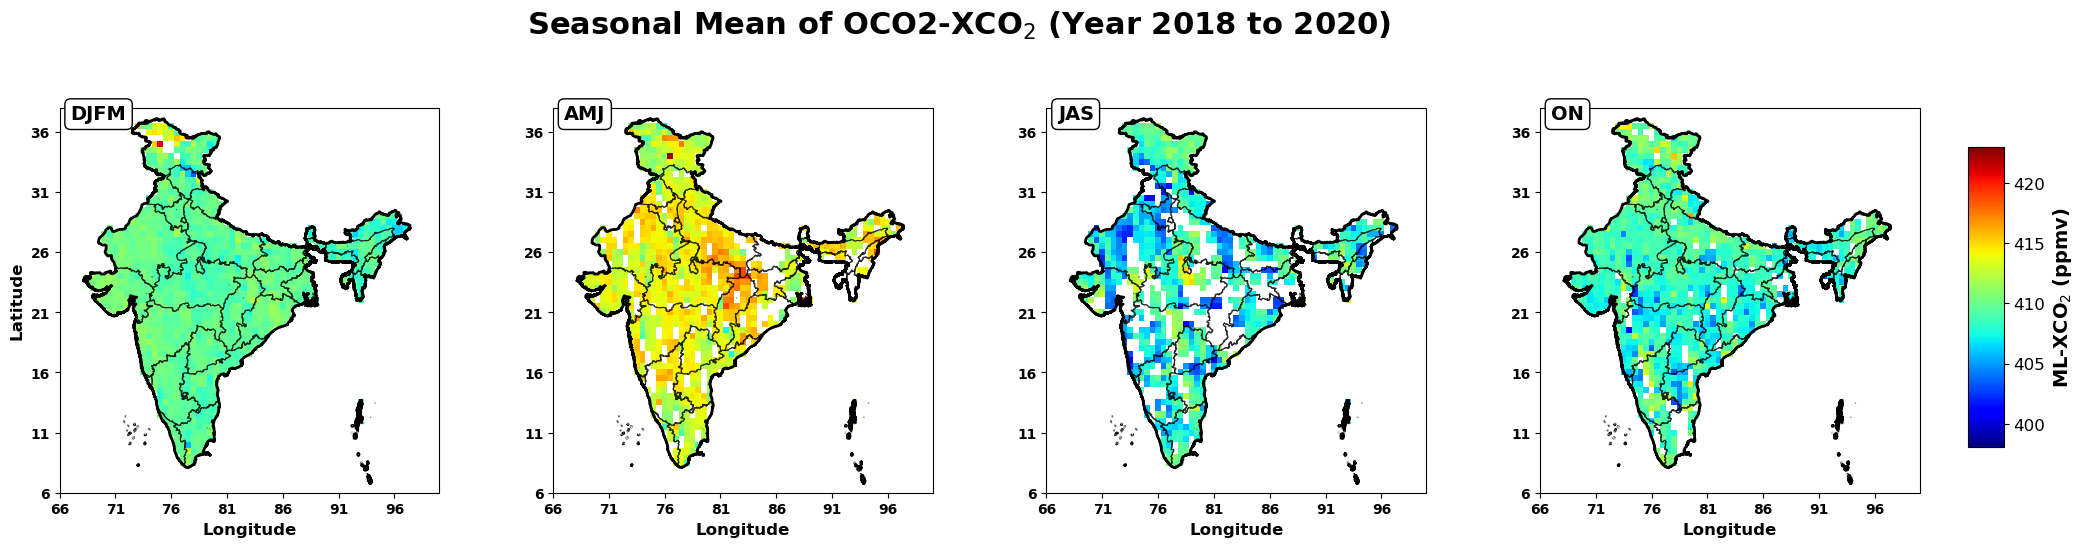

In [7]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point

india_shapefile = r'C:\Users\digvi\India_Boundary.shp'
india_boundary = gpd.read_file(india_shapefile).to_crs(epsg=4326)

district_shapefile = r"D:\project_revived_march_25\india_state\Indian_States.shp"  
district_boundaries = gpd.read_file(district_shapefile)

if district_boundaries.crs is None:
    district_boundaries = district_boundaries.set_crs(epsg=4326) 

district_boundaries = district_boundaries.to_crs(epsg=4326)

ds = xr.open_dataset(r"D:\oco2_retrieval\original_oco2_gridded_2015_20_shifted_lat_lon_0.5_spacing.nc")
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.nc")
ds2 = xr.open_dataset(r"D:\CAMS_3H_MONTHLY_2003_2020\new_CAM_Monthly_2003_2020_075reso_updated_time.nc")
ds3 = xr.open_dataset(r"D:\CT_monthly_files\new_merged_CT_xco2_2003_2020.nc")

ds = ds.sel(latitude=slice(6, 38), longitude=slice(66, 100), time=slice("2018-01-01", "2020-12-01"))
ds = ds.sel(time=slice("2018-01-01", "2020-12-01"))
ds1 = ds1.sel(time=slice("2018-01-01", "2020-12-01"))
ds2 = ds2.sel(time=slice("2018-01-01", "2020-12-01"))
ds3 = ds3.sel(time=slice("2018-01-01", "2020-12-01"))

ds = ds.assign_coords(month=ds["time"].dt.month)
ds1 = ds1.assign_coords(month=ds1["time"].dt.month)
ds2 = ds2.assign_coords(month=ds2["time"].dt.month)
ds3 = ds3.assign_coords(month=ds3["time"].dt.month)

seasons = {"DJFM": [12, 1, 2, 3], "AMJ": [4, 5, 6],
           "JAS": [7, 8, 9], "ON": [10, 11]}

seasonal_avg_oco2 = {season: ds["xco2"].where(ds.month.isin(months)).mean(dim="time") for season, months in seasons.items()}
seasonal_avg_xco2 = {season: ds1["predicted_xco2"].where(ds1.month.isin(months)).mean(dim="time") for season, months in seasons.items()}
seasonal_avg_tcco2 = {season: ds2["tcco2"].where(ds2.month.isin(months)).mean(dim="time") for season, months in seasons.items()}
seasonal_avg_ctco2 = {season: ds3["ctco2"].where(ds3.month.isin(months)).mean(dim="time") for season, months in seasons.items()}


lat_values = ds.latitude.values
lon_values = ds.longitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

points = [Point(lon, lat) for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]
geo_df = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
geo_df = gpd.sjoin(geo_df, india_boundary, how="inner", predicate="within")
inside_points = set(geo_df.geometry.apply(lambda p: (p.x, p.y)))
mask = np.array([(lon, lat) in inside_points for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]).reshape(lat_mesh.shape)

data_values = np.concatenate([seasonal_avg_oco2[s].values.ravel() for s in seasons.keys()])
vmin, vmax = np.nanmin(data_values), np.nanmax(data_values)
if vmin == vmax:
    vmax += 1
fig, axes = plt.subplots(1, 4, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Seasonal Mean of OCO2-XCO$_2$ (Year 2018 to 2020)", fontsize=22, fontweight='bold', color='black')

lon_step = 5  
lat_step = 5  


titles = list(seasons.keys())
for i, ax in enumerate(axes.flat):
    season_data = seasonal_avg_oco2[titles[i]].values
    season_data_masked = np.where(mask, season_data, np.nan)
    
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())

    
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)

    
    im = ax.pcolormesh(lon_mesh, lat_mesh, season_data_masked, cmap='jet', vmin=vmin, vmax=vmax)

    # Season label
    ax.text(67, 37, titles[i], fontsize=14, fontweight='bold', color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    
    ax.set_xticks(np.arange(66, 101, lon_step))
    ax.set_yticks(np.arange(6, 39, lat_step))
    
    ax.set_xticklabels(np.arange(66, 101, lon_step), fontsize=10, fontweight='bold')
    ax.set_yticklabels(np.arange(6, 39, lat_step), fontsize=10, fontweight='bold')

    if i == 0:
        ax.set_ylabel("Latitude", fontsize=12, fontweight='bold', color='black')
    ax.set_xlabel("Longitude", fontsize=12, fontweight='bold', color='black')

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])  
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("ML-XCO$_2$ (ppmv)", fontsize=14, fontweight='bold', color='black')
cbar.ax.tick_params(labelsize=12, labelcolor='black')

plt.subplots_adjust(wspace=0.3, hspace=0.2) 

#plt.savefig(r"D:\project_revived_march_25\26th_Mar_proj_plots\ML_27thMar_Seasonal_mean_XCO2_ML_2018_2020.png", dpi=600, bbox_inches='tight')
plt.show()


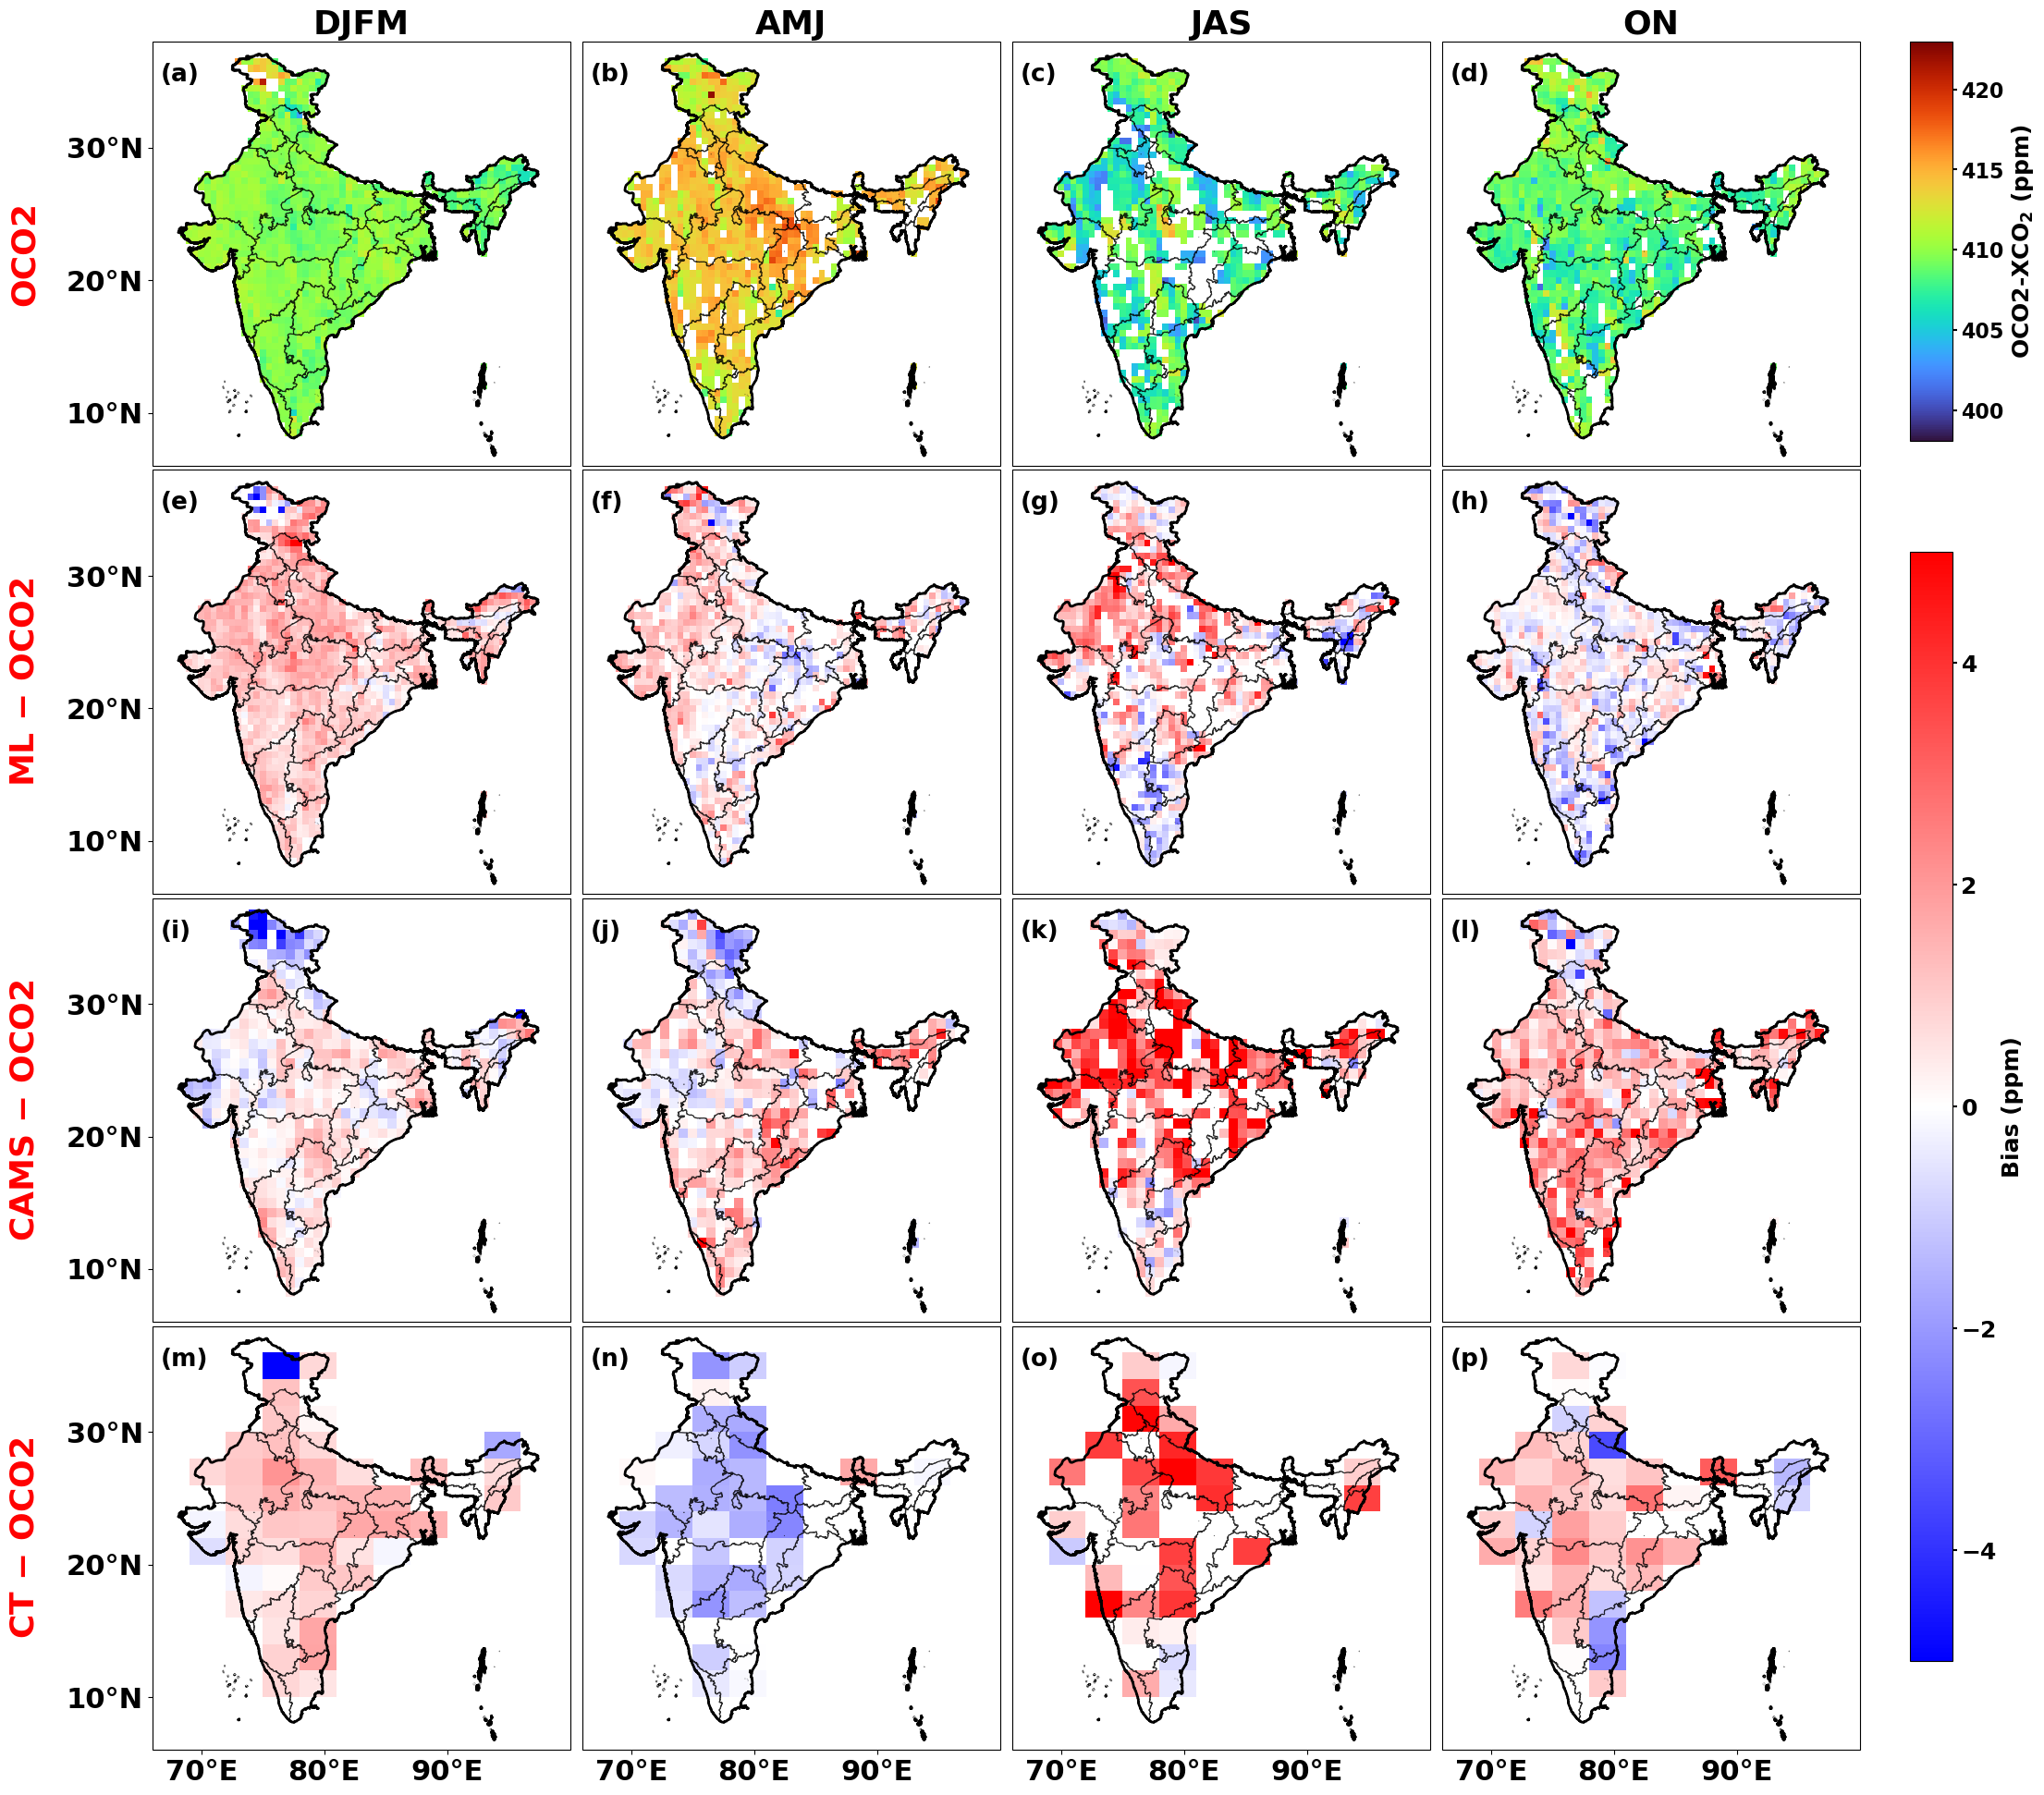

In [8]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

india_shapefile = r'C:\Users\digvi\India_Boundary.shp'
india_boundary = gpd.read_file(india_shapefile).to_crs(epsg=4326)

district_shapefile = r"D:\project_revived_march_25\india_state\Indian_States.shp"
district_boundaries = gpd.read_file(district_shapefile).to_crs(epsg=4326)


ds = ds.sel(latitude=slice(6, 38), longitude=slice(66, 100), time=slice("2018-01-01", "2020-12-01"))
ds1 = ds1.sel(time=slice("2018-01-01", "2020-12-01"))

ds = ds.assign_coords(month=ds["time"].dt.month)
ds1 = ds1.assign_coords(month=ds1["time"].dt.month)

seasons = {"DJFM": [12, 1, 2, 3], "AMJ": [4, 5, 6],
           "JAS": [7, 8, 9], "ON": [10, 11]}


seasonal_avg_xco2 = {season: ds1["predicted_xco2"].where(ds1.month.isin(months)).mean(dim="time") for season, months in seasons.items()}

xco2_aligned, predicted_xco2_aligned = xr.align(ds["xco2"], ds1["predicted_xco2"], join="inner")

seasonal_bias = {
    season: (predicted_xco2_aligned - xco2_aligned)
    .where(predicted_xco2_aligned.month.isin(months))
    .mean(dim="time")
    for season, months in seasons.items()
}
lat_values = ds.latitude.values
lon_values = ds.longitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

points = [Point(lon, lat) for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]
geo_df = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
geo_df = gpd.sjoin(geo_df, india_boundary, how="inner", predicate="within")
inside_points = set(geo_df.geometry.apply(lambda p: (p.x, p.y)))
mask = np.array([(lon, lat) in inside_points for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]).reshape(lat_mesh.shape)

data_values = np.concatenate([seasonal_avg_oco2[s].values.ravel() for s in seasons.keys()])
vmin_mean, vmax_mean = np.nanmin(data_values), np.nanmax(data_values)
if vmin_mean == vmax_mean:
    vmax_mean += 1


bias_values = np.concatenate([seasonal_bias[s].values.ravel() for s in seasons.keys()])


vmin_bias, vmax_bias = -5, 5

if vmin_bias == vmax_bias:
    vmax_bias += 1


fig, axes = plt.subplots(4, 4, figsize=(24, 24), subplot_kw={'projection': ccrs.PlateCarree()})
#fig.suptitle(f"Seasonal Analysis of observed OCO-2 and Biases with ML, CAMS and CT models(2018 to 2020)", fontsize=24, fontweight='bold', color='black'
plt.subplots_adjust(wspace=0.0, hspace=0.01)

lon_step = 5  
lat_step = 5  


lat_values_ds2 = ds2.latitude.values
lon_values_ds2 = ds2.longitude.values
lon_mesh_ds2, lat_mesh_ds2 = np.meshgrid(lon_values_ds2, lat_values_ds2)

lat_values_ds3 = ds3.latitude.values
lon_values_ds3 = ds3.longitude.values
lon_mesh_ds3, lat_mesh_ds3 = np.meshgrid(lon_values_ds3, lat_values_ds3)

titles = list(seasons.keys())


for i, ax in enumerate(axes[0, :]):
    season_data = seasonal_avg_oco2[titles[i]].values
    season_data_masked = np.where(mask, season_data, np.nan)
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)
    im1 = ax.pcolormesh(lon_mesh, lat_mesh, season_data_masked, cmap='turbo', vmin=vmin_mean, vmax=vmax_mean)
    #ax.text(86, 37, titles[i], fontsize=12, fontweight='bold', color='black',
     #       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ax.set_xticks(np.arange(66, 101, lon_step))
    ax.set_yticks(np.arange(6, 39, lat_step))
    ax.set_xticklabels(np.arange(66, 101, lon_step), fontsize=13, fontweight='bold')
    ax.set_yticklabels(np.arange(6, 39, lat_step), fontsize=13, fontweight='bold')
    
for i, ax in enumerate(axes[1, :]):
    season_bias = seasonal_bias[titles[i]].values
    season_bias_masked = np.where(mask, season_bias, np.nan)
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)
    im2 = ax.pcolormesh(lon_mesh, lat_mesh, season_bias_masked, cmap='bwr', vmin=vmin_bias, vmax=vmax_bias)
    #ax.text(86, 37, titles[i], fontsize=12, fontweight='bold', color='black',
           # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ax.set_xticks(np.arange(66, 101, lon_step))
    ax.set_yticks(np.arange(6, 39, lat_step))
    ax.set_xticklabels(np.arange(66, 101, lon_step), fontsize=13, fontweight='bold')
    ax.set_yticklabels(np.arange(6, 39, lat_step), fontsize=13, fontweight='bold')
    

interpolated_xco2 = ds["xco2"].interp(
    latitude=ds2.latitude, longitude=ds2.longitude, method="nearest"
)


seasonal_bias_tcco2 = {season: (ds2["tcco2"] - interpolated_xco2)
                       .where(ds2.month.isin(months)).mean(dim="time") for season, months in seasons.items()}


points_ds2 = [Point(lon, lat) for lon, lat in zip(lon_mesh_ds2.ravel(), lat_mesh_ds2.ravel())]
geo_df_ds2 = gpd.GeoDataFrame(geometry=points_ds2, crs="EPSG:4326")
geo_df_ds2 = gpd.sjoin(geo_df_ds2, india_boundary, how="inner", predicate="within")
inside_points_ds2 = set(geo_df_ds2.geometry.apply(lambda p: (p.x, p.y)))
mask_ds2 = np.array([(lon, lat) in inside_points_ds2 for lon, lat in zip(lon_mesh_ds2.ravel(), lat_mesh_ds2.ravel())]).reshape(lat_mesh_ds2.shape)

titles = list(seasons.keys())
for i, ax in enumerate(axes[2, :]):
    
    season_bias_tcco2 = seasonal_bias_tcco2[titles[i]].values
    season_bias_tcco2_masked = np.where(mask_ds2, season_bias_tcco2, np.nan)  # Apply mask for India boundaries

    
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)
    im3 = ax.pcolormesh(lon_mesh_ds2, lat_mesh_ds2, season_bias_tcco2_masked, cmap='bwr', vmin=vmin_bias, vmax=vmax_bias)

    ax.set_xticks(np.arange(66, 101, lon_step))
    ax.set_yticks(np.arange(6, 39, lat_step))
    ax.set_xticklabels(np.arange(66, 101, lon_step), fontsize=13, fontweight='bold')
    ax.set_yticklabels(np.arange(6, 39, lat_step), fontsize=13, fontweight='bold')

interpolated_xco2 = ds["xco2"].interp(
    latitude=ds3.latitude, longitude=ds3.longitude, method="nearest"
)

seasonal_bias_ctco2 = {season: (ds3["ctco2"] - interpolated_xco2)
                       .where(ds3.month.isin(months)).mean(dim="time") for season, months in seasons.items()}


points_ds3 = [Point(lon, lat) for lon, lat in zip(lon_mesh_ds3.ravel(), lat_mesh_ds3.ravel())]
geo_df_ds3 = gpd.GeoDataFrame(geometry=points_ds3, crs="EPSG:4326")
geo_df_ds3 = gpd.sjoin(geo_df_ds3, india_boundary, how="inner", predicate="within")
inside_points_ds3 = set(geo_df_ds3.geometry.apply(lambda p: (p.x, p.y)))
mask_ds3 = np.array([(lon, lat) in inside_points_ds3 for lon, lat in zip(lon_mesh_ds3.ravel(), lat_mesh_ds3.ravel())]).reshape(lat_mesh_ds3.shape)


titles = list(seasons.keys())
for i, ax in enumerate(axes[3, :]):
    
    season_bias_ctco2 = seasonal_bias_ctco2[titles[i]].values
    season_bias_ctco2_masked = np.where(mask_ds3, season_bias_ctco2, np.nan)  # Apply mask for India boundaries

    
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    district_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.6)
    im4 = ax.pcolormesh(lon_mesh_ds3, lat_mesh_ds3, season_bias_ctco2_masked, cmap='bwr', vmin=vmin_bias, vmax=vmax_bias)

    ax.set_xticks(np.arange(66, 101, lon_step))
    ax.set_yticks(np.arange(6, 39, lat_step))
    ax.set_xticklabels(np.arange(66, 101, lon_step), fontsize=13, fontweight='bold')
    ax.set_yticklabels(np.arange(6, 39, lat_step), fontsize=13, fontweight='bold')




row_titles = [r'OCO2', r'ML $\mathbf{-}$ OCO2', r'CAMS $\mathbf{-}$ OCO2', r'CT $\mathbf{-}$ OCO2']


column_titles = ['DJFM', 'AMJ', 'JAS', 'ON']


for i in range(4):
    for j in range(4):
        
        if j == 0:  
            axes[i, j].set_ylabel(row_titles[i], fontsize=26, fontweight='bold', color='red', labelpad=20)

        
        if i == 0:  
            axes[i, j].set_title(column_titles[j], fontsize=26, fontweight='bold', color='black')

import matplotlib.pyplot as plt
import string


labels = list(string.ascii_lowercase[:16])  
for i in range(4):
    for j in range(4):
        label_index = i * 4 + j
        axes[i, j].text(0.02, 0.95, f'({labels[label_index]})',
                        transform=axes[i, j].transAxes,
                        fontsize=19, fontweight='bold', va='top', ha='left')


cbar_ax1 = fig.add_axes([0.92, 0.70, 0.019, 0.18])  
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label(f"OCO2-X{format_co2_label()} (ppm)", fontsize=18, fontweight='bold', color='black')

cbar1.ax.tick_params(labelsize=16, labelcolor='black', width=1.5)
for label in cbar1.ax.get_yticklabels():
    label.set_fontweight('bold')

cbar_ax_shared = fig.add_axes([0.92, 0.15, 0.019, 0.5])  
cbar_shared = fig.colorbar(im2, cax=cbar_ax_shared)
cbar_shared.set_label("Bias (ppm)", fontsize=18, fontweight='bold', color='black')

cbar_shared.ax.tick_params(labelsize=18, labelcolor='black', width=1.5)
for label in cbar_shared.ax.get_yticklabels():
    label.set_fontweight('bold')


for i, ax in enumerate(axes.flat):
    if i % 4 == 0:  

        ax.set_yticks(np.arange(10, 37, 10))
        ax.set_yticklabels([f"{y}°N" for y in np.arange(10, 37, 10)], fontsize=22, fontweight='bold')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    if i >= 12:  
        
        ax.set_xticks(np.arange(70, 97, 10))
        ax.set_xticklabels([f"{x}°E" for x in np.arange(70, 97, 10)], fontsize=22, fontweight='bold')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

#plt.savefig(r"D:\Results_turbo\200ep1stFeb_Seasonal_Bias_withorgOCO2_2018_2020_ML_CT_CAMS_with_OCO2.png", dpi=600, bbox_inches='tight')
#plt.savefig(r"D:\15thJul_Results\New folder\11Aug_Seasonal_Bias_withorgOCO2_2018_2020_ML_CT_CAMS_with_OCO2.png", dpi=600, bbox_inches='tight')
plt.show()


C:\Users\digvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\digvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\digvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\digvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

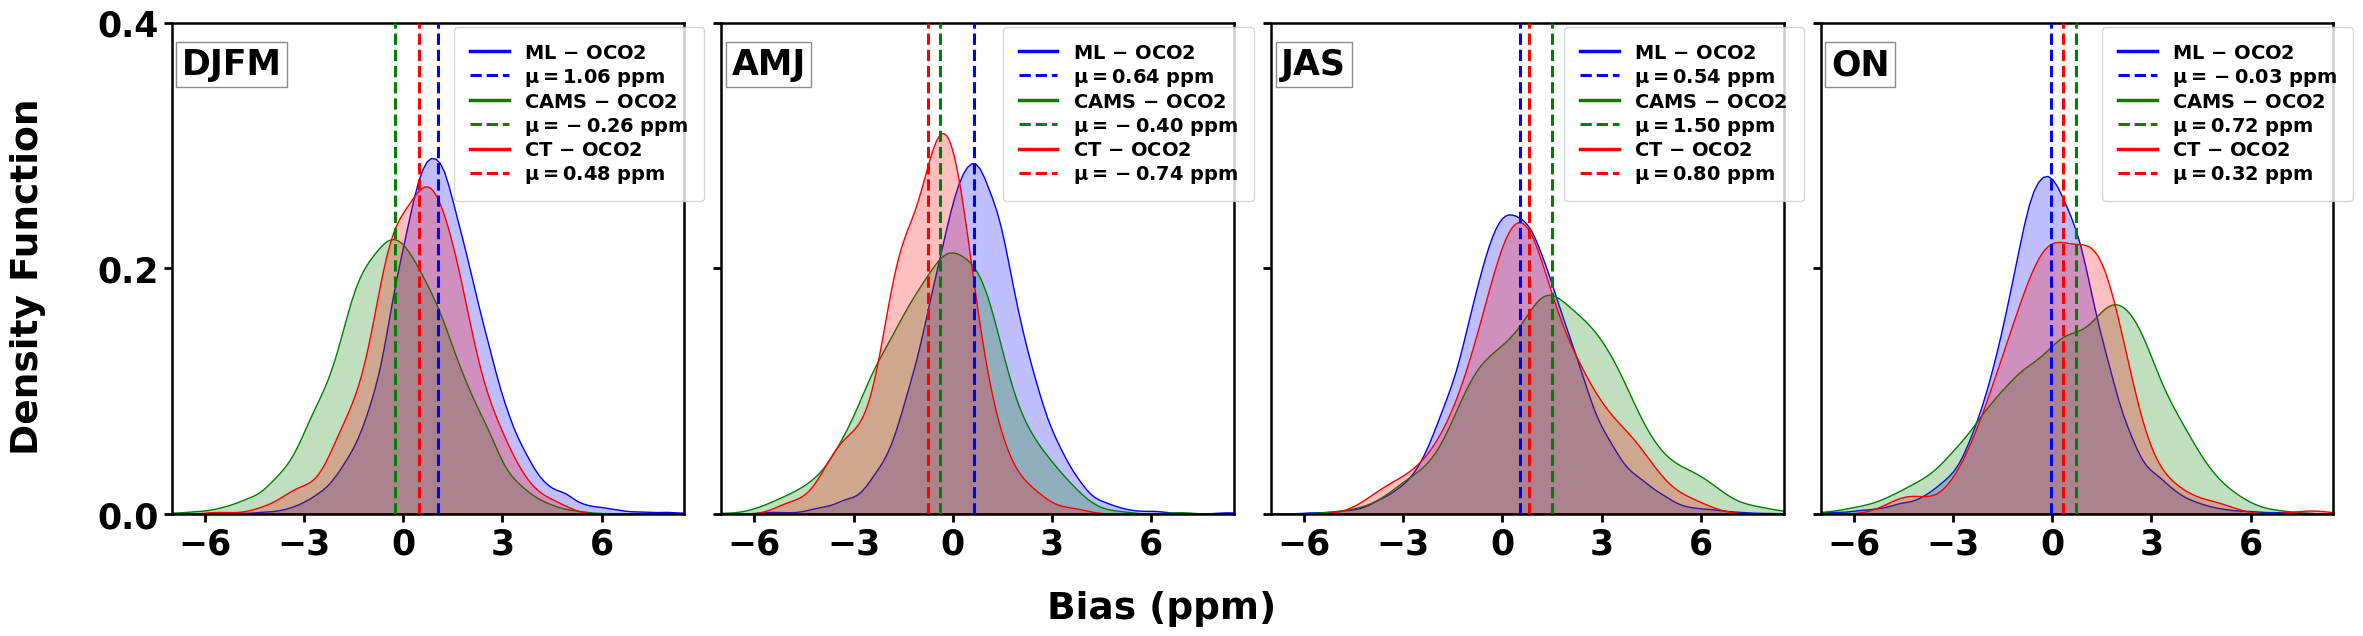

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D

seasons = {
    "DJFM": [12, 1, 2, 3],
    "AMJ": [4, 5, 6],
    "JAS": [7, 8, 9],
    "ON": [10, 11]
}
def create_legend_entries(label, color, mean_value):
    line = Line2D([0], [0], color=color, lw=2.5)
    mean = Line2D([0], [0], color=color, linestyle="--", lw=2.2)

    
    minus_sign = "\u2212" if mean_value < 0 else ""
    formatted_mean = rf"$\mathbf{{\mu = {minus_sign}{abs(mean_value):.2f}}}$ ppm"

    return [(line, label), (mean, formatted_mean)]

fig, axes = plt.subplots(1, len(seasons), figsize=(24, 6), sharey=True)

if len(seasons) == 1:
    axes = [axes]


for i, (season, months) in enumerate(seasons.items()):
    ax = axes[i]

    
    bias_ml = (ds1["predicted_xco2"] - ds["xco2"]).where(ds1.month.isin(months)).values.flatten()
    bias_cams = (ds2["tcco2"] - ds["xco2"].interp(latitude=ds2.latitude, longitude=ds2.longitude)).where(ds2.month.isin(months)).values.flatten()
    bias_ct = (ds3["ctco2"] - ds["xco2"].interp(latitude=ds3.latitude, longitude=ds3.longitude)).where(ds3.month.isin(months)).values.flatten()

    
    bias_ml = bias_ml[~np.isnan(bias_ml)]
    bias_cams = bias_cams[~np.isnan(bias_cams)]
    bias_ct = bias_ct[~np.isnan(bias_ct)]

    
    mean_ml = np.mean(bias_ml)
    mean_cams = np.mean(bias_cams)
    mean_ct = np.mean(bias_ct)

    
    sns.kdeplot(bias_ml, ax=ax, color="blue", fill=True, zorder=2)
    sns.kdeplot(bias_cams, ax=ax, color="green", fill=True, zorder=2)
    sns.kdeplot(bias_ct, ax=ax, color="red", fill=True, zorder=2)
    ax.set_ylabel('')

    
    ax.axvline(mean_ml, color="blue", linestyle="--", linewidth=2.2, zorder=3)
    ax.axvline(mean_cams, color="green", linestyle="--", linewidth=2.2, zorder=3)
    ax.axvline(mean_ct, color="red", linestyle="--", linewidth=2.2, zorder=3)

    
    ax.text(0.02, 0.95, season, transform=ax.transAxes, fontsize=25, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

    ax.set_xlim(-7, 8.5)
    ax.set_xticks(np.arange(-6, 7, 3))  


    for tick_label in ax.get_xticklabels():
        tick_label.set_weight("bold")
        tick_label.set_color("black")


    ax.set_yticks(np.arange(0, 0.6, 0.2))


    legend_items = []
    legend_items += create_legend_entries(r"ML $\mathbf{-}$ OCO2", "blue", mean_ml)
    legend_items += create_legend_entries(r"CAMS $\mathbf{-}$ OCO2", "green", mean_cams)
    legend_items += create_legend_entries(r"CT $\mathbf{-}$ OCO2", "red", mean_ct)
    handles, labels = zip(*legend_items)

    ax.legend(handles, labels,
              loc='upper right',
              bbox_to_anchor=(1.058, 1.01),        
              fontsize=14,                     
              frameon=True,
              fancybox=True,
              borderpad=0.8,
              labelspacing=0.2,
              prop={'weight': 'bold', 'size': 14, 'family': 'DejaVu Sans'}) 




    ax.tick_params(axis='both', labelsize=25, width=2, color='black', length=6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_weight("bold")
        label.set_color("black")
    for spine in ax.spines.values():
        spine.set_linewidth(1.8)
        spine.set_color("black")


fig.text(0.02, 0.5, "Density Function", va='center', rotation='vertical',
         fontsize=27, fontweight="bold", color="black")

# Shared X-axis label
fig.text(0.5, -0.07, "Bias (ppm)", ha='center',
         fontsize=27, fontweight="bold", color="black")


plt.tight_layout(rect=[0.05, 0, 1, 0.97])
for ax in axes:
    for tick_label in ax.get_xticklabels():
        tick_label.set_weight("bold")
        tick_label.set_color("black")

#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\200ep15thOCT_kernelDensity_org_OCO2_biases_ML_CAMS_CT.png", dpi=600, bbox_inches='tight')
plt.show()


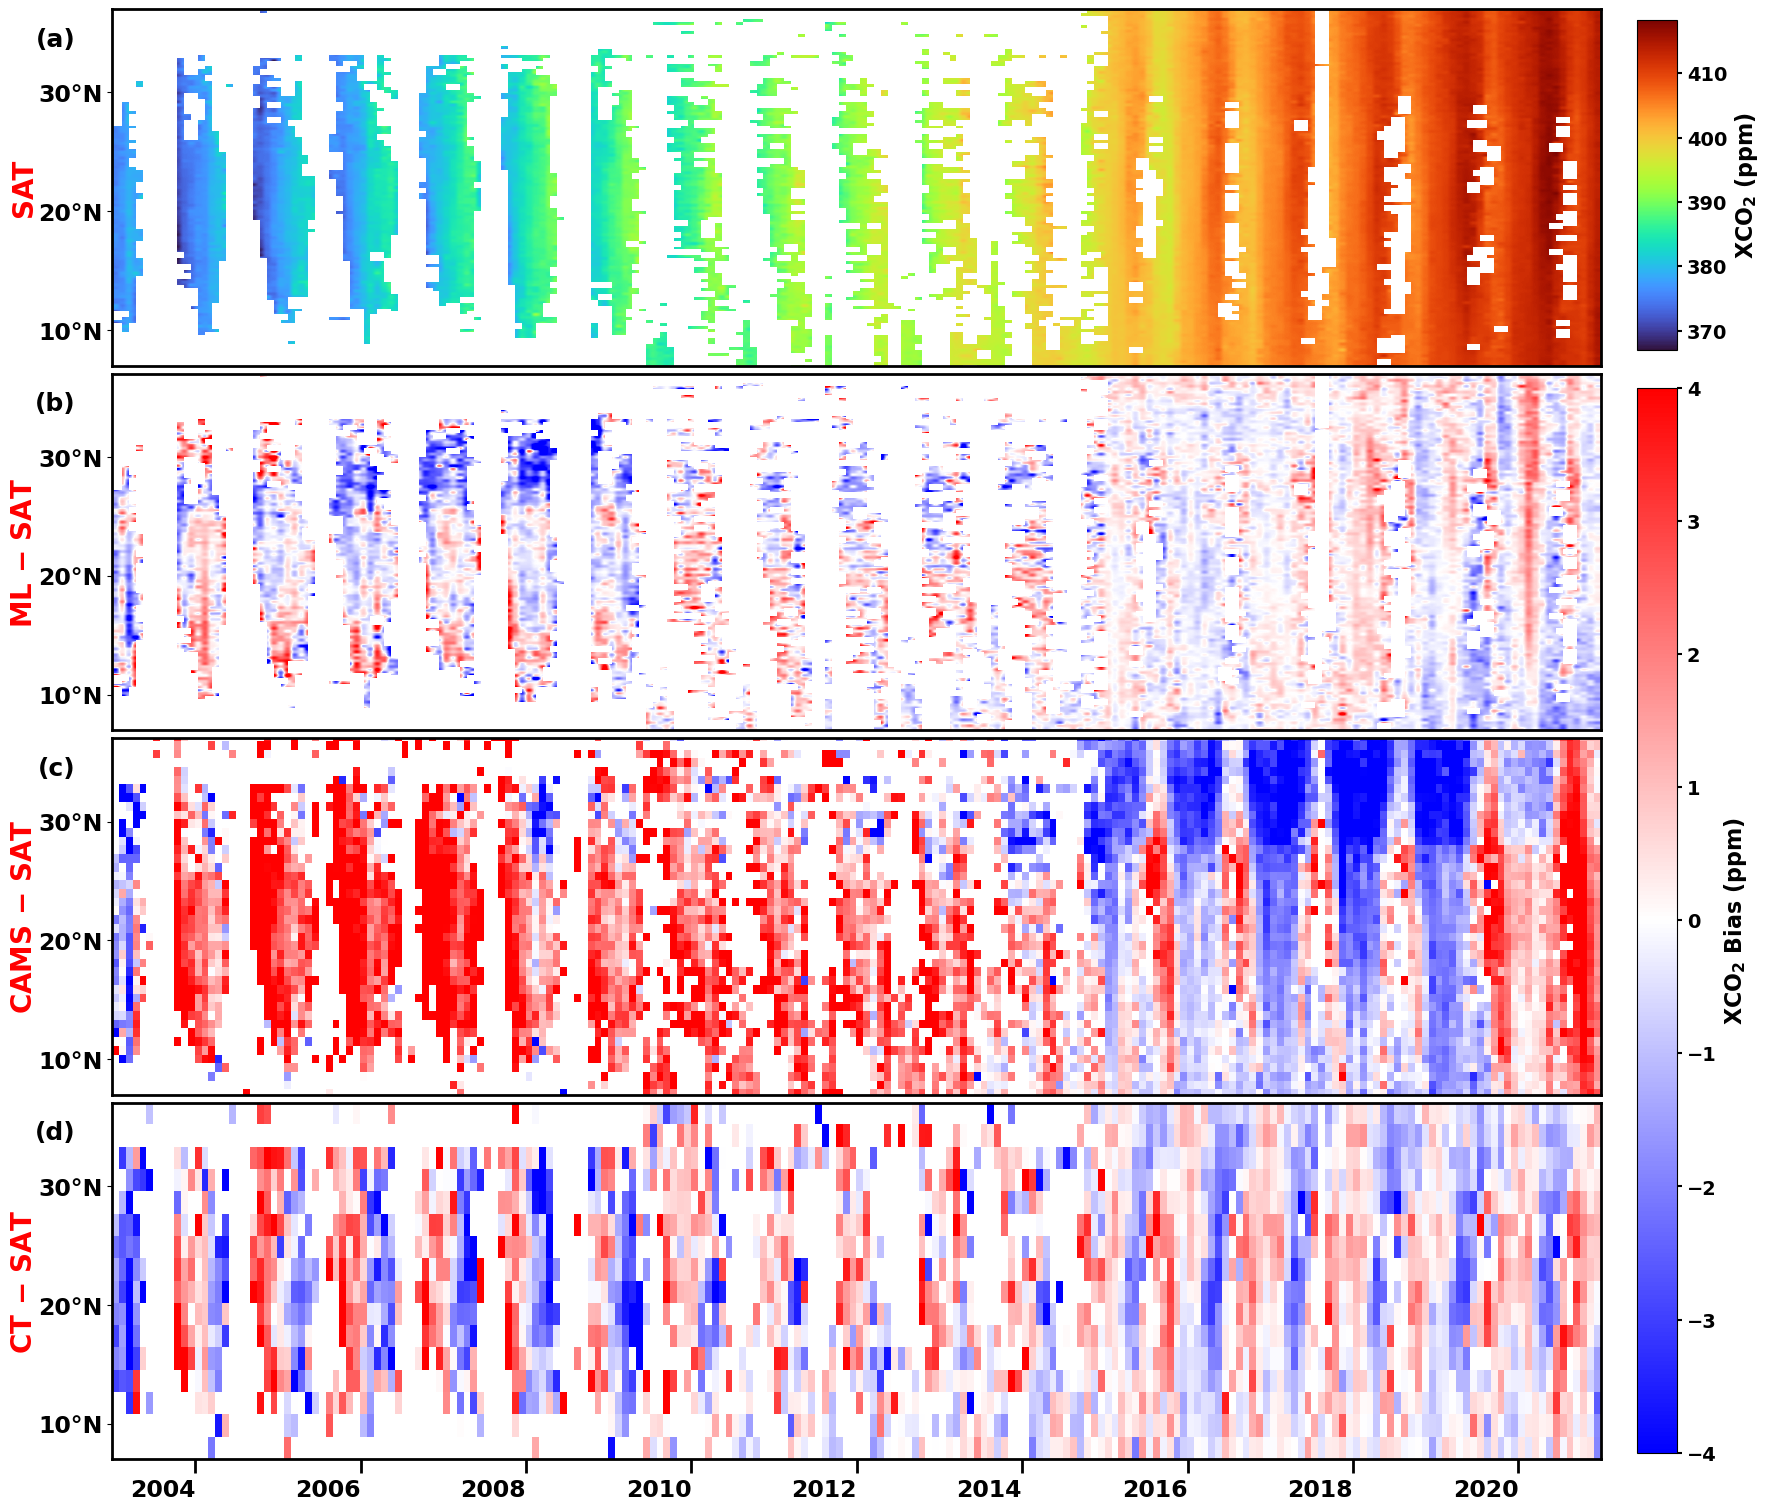

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
ds = xr.open_dataset(r"D:\project_revived_march_25\OCO2_new\11thOCT_satellite_merged_gridded_dataset_complete.nc")
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")
ds2 = xr.open_dataset(r"D:\CAMS_3H_MONTHLY_2003_2020\new_CAM_Monthly_2003_2020_075reso_updated_time.nc")
ds3 = xr.open_dataset(r"D:\CT_monthly_files\new_merged_CT_xco2_2003_2020.nc")


ds = ds.sel(latitude=slice(6, 38), longitude=slice(66, 100), time=slice("2003-01-01", "2020-12-31"))
ds1 = ds1.sel(time=slice("2003-01-01", "2020-12-31"))
ds2 = ds2.sel(time=slice("2003-01-01", "2020-12-31"))
ds3 = ds3.sel(time=slice("2003-01-01", "2020-12-31"))
ds = ds.assign_coords(month=ds["time"].dt.month)
ds1 = ds1.assign_coords(month=ds1["time"].dt.month)
ds2 = ds2.assign_coords(month=ds2["time"].dt.month)
ds3 = ds3.assign_coords(month=ds3["time"].dt.month)

for d in [ds, ds1, ds2, ds3]:
    d["month"] = d["time"].dt.month
    d["year"] = d["time"].dt.year

def compute_lat_time_monthly(data):
    return data.groupby("time").mean("longitude")

oco2_monthly = compute_lat_time_monthly(ds["xco2_adjusted"])
ml_monthly = compute_lat_time_monthly(ds1["predicted_xco2"])
cams_monthly = compute_lat_time_monthly(ds2["tcco2"])
ct_monthly = compute_lat_time_monthly(ds3["ctco2"])

bias_ml = ml_monthly - oco2_monthly
bias_cams = cams_monthly - oco2_monthly
bias_ct = ct_monthly - oco2_monthly

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 15), constrained_layout=True, sharex=True, sharey=True)
row_titles = [r"SAT", r"ML $\mathbf{-}$ SAT", r"CAMS $\mathbf{-}$ SAT", r"CT $\mathbf{-}$ SAT"]

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

def plot_lat_time(ax, data, vmin=None, vmax=None, cmap='turbo'):
    data_plot = data.transpose("latitude", "time")
    times = data.time.dt.strftime('%Y-%m').values
    lats = data.latitude.values

    im = ax.imshow(data_plot, aspect='auto', origin='lower', cmap=cmap,
                   extent=[0, len(times), lats[0], lats[-1]],
                   vmin=vmin, vmax=vmax)

    ax.tick_params(left=True, labelleft=True, bottom=False, labelbottom=False)
    return im

# Row 1: Satellite data
im0 = plot_lat_time(axes[0], oco2_monthly, cmap='turbo')

# Rows 2-4: Biases
plot_lat_time(axes[1], bias_ml, vmin=-3, vmax=3, cmap='bwr')
plot_lat_time(axes[2], bias_cams, vmin=-3, vmax=3, cmap='bwr')
plot_lat_time(axes[3], bias_ct, vmin=-3, vmax=3, cmap='bwr')

for i, ax in enumerate(axes):
    ax.text(-0.050, 0.5, row_titles[i], transform=ax.transAxes,
            fontsize=20, fontweight='bold', color='red', va='center', ha='right', rotation=90)

lat_vals = np.arange(10, 40, 10)
for ax in axes:
    ax.set_yticks(lat_vals)
    ax.set_yticklabels([f"{lat}°N" for lat in lat_vals], fontsize=17, fontweight='bold', color='black')

axes[3].tick_params(bottom=True, labelbottom=True)

times = oco2_monthly.time.to_index()

xticks = [i for i, t in enumerate(times) if t.month == 1 and t.year % 2 == 0]
xticklabels = [str(times[i].year) for i in xticks]

axes[3].set_xticks(xticks)
axes[3].set_xticklabels(xticklabels, fontsize=17, rotation=0, ha='right', fontweight='bold')

axes[3].tick_params(axis='x', which='major', bottom=True, labelbottom=True,
                    length=10,  
                    width=2,    
                    color='black',  
                    direction='out')  


for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  

import string

labels = list(string.ascii_lowercase[:4]) 

for i in range(4):
    axes[i].text(-0.025, 0.95, f'({labels[i]})',
                 transform=axes[i].transAxes,
                 fontsize=18, fontweight='bold', va='top', ha='right')

cbar_ax1 = fig.add_axes([1.02, 0.77, 0.025, 0.22])
cbar1 = fig.colorbar(im0, cax=cbar_ax1)
cbar1.set_label(f"X{format_co2_label()} (ppm)", fontsize=16, fontweight='bold')
cbar1.ax.tick_params(labelsize=14, width=1.5)
for label in cbar1.ax.get_yticklabels(): label.set_fontweight('bold')

cbar_ax2 = fig.add_axes([1.02, 0.035, 0.025, 0.71])
im_bias = plt.cm.ScalarMappable(cmap='bwr')
im_bias.set_clim(-4, 4)
cbar2 = fig.colorbar(im_bias, cax=cbar_ax2)
cbar2.set_label(f"X{format_co2_label()} Bias (ppm)", fontsize=16, fontweight='bold')
cbar2.ax.tick_params(labelsize=14, width=1.5)
for label in cbar2.ax.get_yticklabels(): label.set_fontweight('bold')

#plt.savefig(r"D:\24thJAN_DNN_MTech\200ep24thJAN_monthly_latVariation_ML_CT_CAMS_SAT.png", dpi=600, bbox_inches='tight')
plt.show()


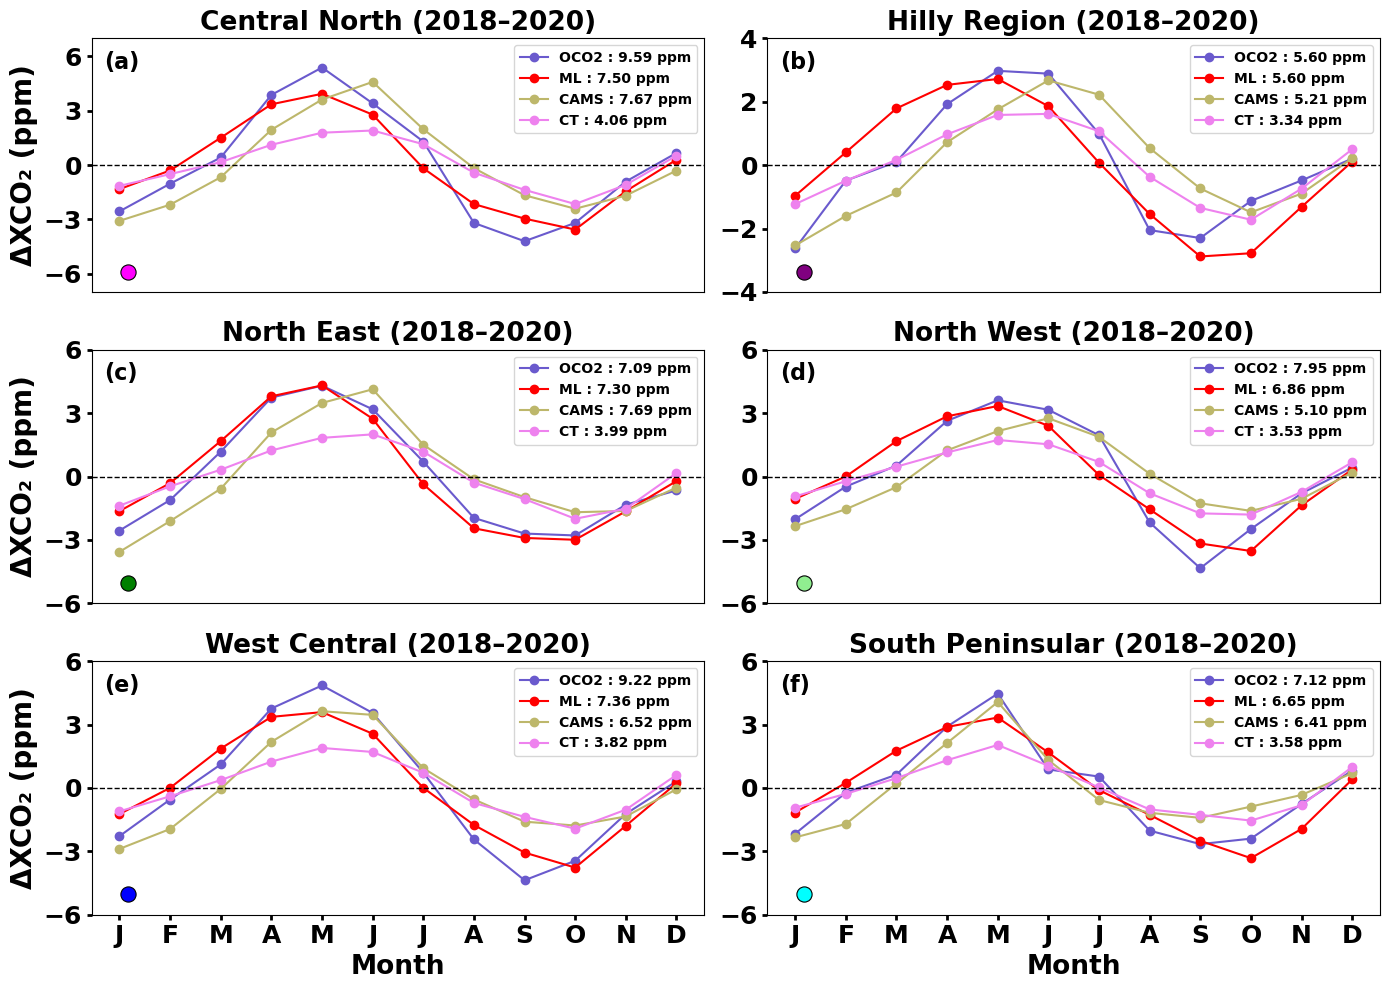


Performance Metrics (RMSE, CC) w.r.t OCO-2:

Region: Central North
  ML   -> RMSE: 0.973, CC: 0.957**
  CAMS -> RMSE: 1.562, CC: 0.849**
  CT   -> RMSE: 1.871, CC: 0.912**

Region: Hilly Region
  ML   -> RMSE: 1.031, CC: 0.844**
  CAMS -> RMSE: 1.159, CC: 0.777**
  CT   -> RMSE: 0.942, CC: 0.909**

Region: North East
  ML   -> RMSE: 0.556, CC: 0.975**
  CAMS -> RMSE: 1.212, CC: 0.872**
  CT   -> RMSE: 1.393, CC: 0.914**

Region: North West
  ML   -> RMSE: 0.908, CC: 0.926**
  CAMS -> RMSE: 1.359, CC: 0.841**
  CT   -> RMSE: 1.305, CC: 0.968**

Region: West Central
  ML   -> RMSE: 0.807, CC: 0.969**
  CAMS -> RMSE: 1.351, CC: 0.895**
  CT   -> RMSE: 1.704, CC: 0.958**

Region: South Peninsular
  ML   -> RMSE: 0.809, CC: 0.924**
  CAMS -> RMSE: 0.882, CC: 0.911**
  CT   -> RMSE: 1.078, CC: 0.958**


In [11]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import string

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'

# Load datasets
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")
ds2 = xr.open_dataset(r"D:/CAMS_3H_MONTHLY_2003_2020/new_CAM_Monthly_2003_2020_075reso_updated_time.nc")
ds3 = xr.open_dataset(r"D:/CT_monthly_files/new_merged_CT_xco2_2003_2020.nc")
ds4 = xr.open_dataset(r"D:\oco2_retrieval\original_oco2_gridded_2015_20_shifted_lat_lon_0.5_spacing.nc")

start_date = "2018-01-01"
end_date = "2020-12-01"

variables = {
    "xco2": ds4['xco2'].sel(time=slice(start_date, end_date)).where(~np.isnan(ds4['xco2'])),
    "predicted_xco2": ds1['predicted_xco2'].sel(time=slice(start_date, end_date)),
    "tcco2": ds2['tcco2'].sel(time=slice(start_date, end_date)),
    "ctco2": ds3['ctco2'].sel(time=slice(start_date, end_date))
}

for var in variables:
    variables[var] = variables[var].assign_coords(time=pd.to_datetime(variables[var].time.values))


land_shapefiles = {
    "Central North": r"D:\shapefile_rainfall\Central_Northeast.shp",
    "Hilly Region": r"D:\shapefile_rainfall\Hilly_Regions.shp",
    "North East": r"D:\shapefile_rainfall\Northeast.shp",
    "North West": r"D:\shapefile_rainfall\Northwest.shp",
    "West Central": r"D:\project_revived_march_25\rainfall_regions\WCI_region.shp",
    "South Peninsular": r"D:\project_revived_march_25\rainfall_regions\SPI_region.shp"
}
region_dot_colors = {
    "Central North": "magenta",
    "Hilly Region": "purple",
    "North East": "green",
    "North West": "lightgreen",
    "West Central": "blue",
    "South Peninsular": "cyan"
}

colors = {
    "xco2": "slateblue",
    "predicted_xco2": "red",
    "tcco2": "darkkhaki",
    "ctco2": "violet"
}

def filter_by_shape(ds, shapefile_path):
    gdf = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
    ds = ds.rio.write_crs("EPSG:4326")
    try:
        return ds.rio.clip(gdf.geometry, gdf.crs, drop=False, all_touched=True)
    except Exception as e:
        print(f"Clipping failed for {shapefile_path}: {e}")
        return ds
def centered_yticks_for_range(vmax, nticks=5):
    """
    Given the *axis limit* vmax (>0), return symmetric, evenly spaced tick
    locations *inside* that limit, leaving the extreme ends unlabeled.
    
    We return up to 5 ticks: [-label_max, -label_max/2, 0, label_max/2, label_max]
    where label_max is the largest even integer <= floor(vmax).
    """
    vmax = float(vmax)
    if vmax <= 0:
        return [0]

    label_max = int(np.floor(vmax))
    if label_max < 2:
        return [-label_max, 0, label_max]

    if label_max % 2 != 0:
        label_max -= 1
        if label_max < 2:  
            label_max = 2

    step = label_max // 2
    ticks = np.arange(-label_max, label_max + step, step)
    return ticks.tolist()

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.0, hspace=0.01)

metrics_dict = {
    "Region": [],
    "ML": [],
    "CAMS": [],
    "CT": []
}

for idx, (land_type, shapefile_path) in enumerate(land_shapefiles.items()):
    ax = axes[idx]
    ax.set_title(f'{land_type} (2018–2020)', fontsize=19, fontweight='bold', color='black')
    legend_labels = {}

    base_oco2_anomaly = None
    metrics_per_region = {}

    for var_name, ds in variables.items():
        filtered_ds = filter_by_shape(ds, shapefile_path)
        filtered_ds = filtered_ds.assign_coords(month=filtered_ds.time.dt.month)

        monthly_means = filtered_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'], skipna=True)
        monthly_clim = monthly_means.mean(dim='month', skipna=True)
        anomalies = monthly_means - monthly_clim
        amplitude = (monthly_means.max() - monthly_means.min()).item()

        short_name_map = {
            "xco2": "OCO2",
            "predicted_xco2": "ML",
            "tcco2": "CAMS",
            "ctco2": "CT"
        }
        legend_labels[var_name] = f"{short_name_map[var_name]} : {amplitude:.2f} ppm"

        df_anomalies = anomalies.to_dataframe().reset_index()

        ax.plot(df_anomalies['month'], df_anomalies[var_name],
                marker='o', linestyle='-', color=colors[var_name],
                label=legend_labels[var_name])

        if var_name == "xco2":
            base_oco2_anomaly = df_anomalies[var_name].values
        elif var_name in ["predicted_xco2", "tcco2", "ctco2"]:
            model_vals = df_anomalies[var_name].values
            if base_oco2_anomaly is not None and len(model_vals) == len(base_oco2_anomaly):
                rmse = np.sqrt(mean_squared_error(base_oco2_anomaly, model_vals))
                cc, p_val = pearsonr(base_oco2_anomaly, model_vals)
                metrics_per_region[var_name] = (rmse, cc, p_val)

    metrics_dict["Region"].append(land_type)
    metrics_dict["ML"].append(metrics_per_region.get("predicted_xco2", (None, None, None)))
    metrics_dict["CAMS"].append(metrics_per_region.get("tcco2", (None, None, None)))
    metrics_dict["CT"].append(metrics_per_region.get("ctco2", (None, None, None)))

    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    all_y_values = []
    for var_name, ds in variables.items():
        filtered_ds = filter_by_shape(ds, shapefile_path)
        filtered_ds = filtered_ds.assign_coords(month=filtered_ds.time.dt.month)
        monthly_means = filtered_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'], skipna=True)
        monthly_clim = monthly_means.mean(dim='month', skipna=True)
        anomalies = monthly_means - monthly_clim
        all_y_values.extend(anomalies.values.ravel())

    all_y_values = np.asarray(all_y_values)
    all_y_values = all_y_values[~np.isnan(all_y_values)]

    if len(all_y_values) == 0:
        max_val = 1.0
    else:
        max_val = np.max(np.abs(all_y_values)) * 1.2 

    max_val = float(np.ceil(max_val))  

    yticks = centered_yticks_for_range(max_val)

    ax.set_ylim(-max_val, max_val)
    ax.set_yticks(yticks)



    if idx % 2 == 0:
        ax.set_ylabel('ΔXCO₂ (ppm)', fontsize=20, fontweight='bold', color='black')

    if idx in [4, 5]:
        ax.set_xlabel('Month', fontsize=19, fontweight='bold', color='black')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],
                           fontsize=19, fontweight='bold', color='black')
    else:
        ax.set_xticks([])

    ax.tick_params(axis='both', labelsize=18, width=2, colors='black')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_weight("bold")
        label.set_color("black")

    ax.legend(loc='upper right', fontsize=15, frameon=True, prop={'weight': 'bold'})
    dot_color = region_dot_colors.get(land_type, "black")

    ax.scatter(
        0.06, 0.08,          
        s=120,
        color=dot_color,
        edgecolor='black',
        linewidth=0.8,
        transform=ax.transAxes,
        zorder=10
    )

labels = list(string.ascii_lowercase[:6])
for idx, label in enumerate(labels):
    axes[idx].text(0.02, 0.95, f'({label})',
                   transform=axes[idx].transAxes,
                   fontsize=16, fontweight='bold', va='top', ha='left')


plt.tight_layout()
#plt.savefig(r"D:\24thJAN_DNN_MTech\new200ep24thJAN_homogeneousRainfall_sc_2018_2020.png", dpi=600, bbox_inches='tight')
plt.show()

print("\nPerformance Metrics (RMSE, CC) w.r.t OCO-2:")
def format_stat(value, p_value):
    if value is None or np.isnan(value):
        return "NA"
    significance = ""
    if p_value is not None:
        if p_value < 0.01:
            significance = "**"
        elif p_value < 0.05:
            significance = "*"
    return f"{value:.3f}{significance}"

for i, region in enumerate(metrics_dict["Region"]):
    ml_rmse, ml_cc, ml_p = metrics_dict["ML"][i]
    cams_rmse, cams_cc, cams_p = metrics_dict["CAMS"][i]
    ct_rmse, ct_cc, ct_p = metrics_dict["CT"][i]

    print(f"\nRegion: {region}")
    print(f"  ML   -> RMSE: {format_stat(ml_rmse, None)}, CC: {format_stat(ml_cc, ml_p)}")
    print(f"  CAMS -> RMSE: {format_stat(cams_rmse, None)}, CC: {format_stat(cams_cc, cams_p)}")
    print(f"  CT   -> RMSE: {format_stat(ct_rmse, None)}, CC: {format_stat(ct_cc, ct_p)}")


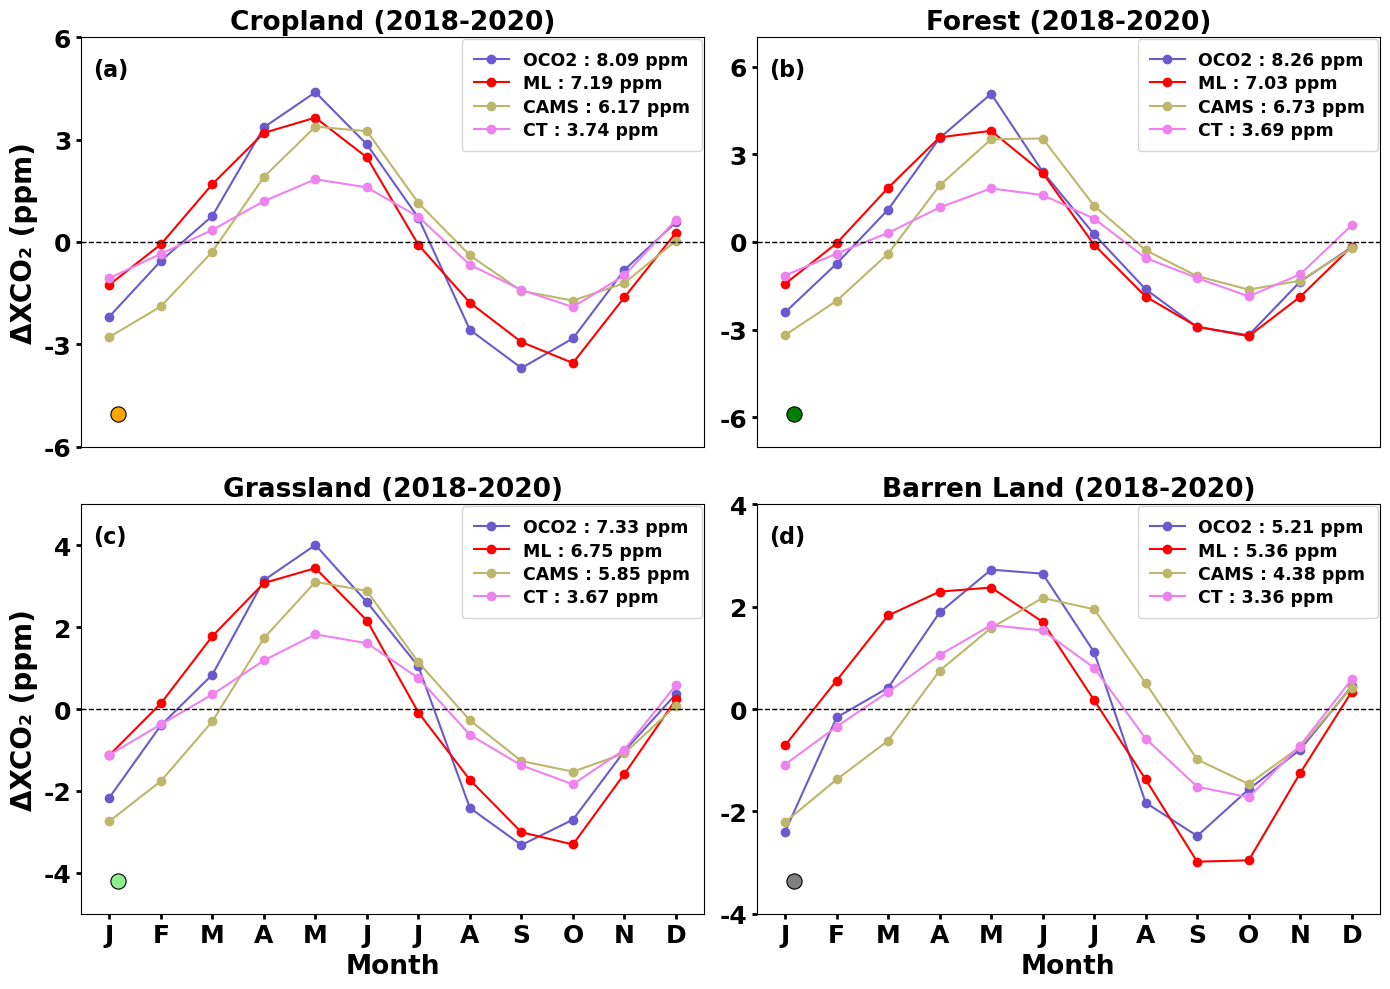


=== Correlation & RMSE vs OCO-2 ===

Region: Cropland
ML - CC: 0.962**, RMSE: 0.695**
CAMS - CC: 0.874**, RMSE: 1.233**
CT - CC: 0.950**, RMSE: 1.415**

Region: Forest
ML - CC: 0.974**, RMSE: 0.582**
CAMS - CC: 0.865**, RMSE: 1.260**
CT - CC: 0.936**, RMSE: 1.464**

Region: Grassland
ML - CC: 0.959**, RMSE: 0.665**
CAMS - CC: 0.868**, RMSE: 1.178**
CT - CC: 0.957**, RMSE: 1.251**

Region: Barren Land
ML - CC: 0.870**, RMSE: 0.914**
CAMS - CC: 0.798**, RMSE: 1.073**
CT - CC: 0.956**, RMSE: 0.791**


In [12]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray 

# Load datasets
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")
ds2 = xr.open_dataset(r"D:/CAMS_3H_MONTHLY_2003_2020/new_CAM_Monthly_2003_2020_075reso_updated_time.nc")
ds3 = xr.open_dataset(r"D:/CT_monthly_files/new_merged_CT_xco2_2003_2020.nc")
ds4 = xr.open_dataset(r"D:\oco2_retrieval\original_oco2_gridded_2015_20_shifted_lat_lon_0.5_spacing.nc")

start_date = "2018-01-01"
end_date = "2020-12-01"

variables = {
    "xco2": ds4['xco2'].sel(time=slice(start_date, end_date)).where(~np.isnan(ds4['xco2'])),
    "predicted_xco2": ds1['predicted_xco2'].sel(time=slice(start_date, end_date)),
    "tcco2": ds2['tcco2'].sel(time=slice(start_date, end_date)),
    "ctco2": ds3['ctco2'].sel(time=slice(start_date, end_date))
}

for var in variables:
    variables[var] = variables[var].assign_coords(time=pd.to_datetime(variables[var].time.values))

land_shapefiles = {
    "Cropland": r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\country_land_cover_shapefiles_coarse\cropland.shp",
    "Forest": r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\country_land_cover_shapefiles_coarse\forest.shp",
    "Grassland": r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\country_land_cover_shapefiles_coarse\grassland.shp",
    "Barren Land": r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\country_land_cover_shapefiles_coarse\barren.shp",
}
region_dot_colors = {
    "Cropland": "orange",
    "Forest": "green",
    "Grassland": "lightgreen",
    "Barren Land": "grey",
}

colors = {
    "xco2": "slateblue",
    "predicted_xco2": "red",
    "tcco2": "darkkhaki",
    "ctco2": "violet"
}

def filter_by_shape(ds, shapefile_path):
    gdf = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
    ds = ds.rio.write_crs("EPSG:4326")
    try:
        mask = ds.rio.clip(gdf.geometry, gdf.crs, drop=False, all_touched=True)
    except Exception as e:
        print(f"Clipping failed for {shapefile_path}: {e}")
        return ds
    return mask

def centered_yticks_for_range(vmax):
    """
    Given a symmetric axis half‑range vmax (>0), return evenly spaced
    interior tick locations that do NOT sit on the axis extremes.

    Pattern (preferred): [-L, -L/2, 0, L/2, L]
    where L is the largest *even* integer <= floor(vmax).

    Falls back to [-L, 0, L] for very small ranges.
    """
    vmax = float(vmax)
    if vmax <= 0:
        return [0]

    label_max = int(np.floor(vmax))
    if label_max < 2:
        return [-label_max, 0, label_max]

    if label_max % 2 != 0:
        label_max -= 1
        if label_max < 2:
            label_max = 2

    step = label_max // 2  
    ticks = np.arange(-label_max, label_max + step, step)
    return ticks.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.0, hspace=0.01)
axes = axes.flatten()  

for idx, (land_type, shapefile_path) in enumerate(land_shapefiles.items()):
    ax = axes[idx]  
    ax.set_title(f'{land_type} (2018-2020)', fontsize=19, fontweight='bold', color='black')

    legend_labels = {}

    for var_name, ds in variables.items():
        filtered_ds = filter_by_shape(ds, shapefile_path)

        filtered_ds = filtered_ds.assign_coords(month=filtered_ds.time.dt.month)
        monthly_means = filtered_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'], skipna=True)
        monthly_climatology = monthly_means.mean(dim='month', skipna=True)

        anomalies = monthly_means - monthly_climatology
        amplitude = (monthly_means.max() - monthly_means.min()).item()

        short_name_map = {
            "xco2": "OCO2",
            "predicted_xco2": "ML",
            "tcco2": "CAMS",
            "ctco2": "CT"
        }
        legend_labels[var_name] = f"{short_name_map[var_name]} : {amplitude:.2f} ppm"

        df_anomalies = anomalies.to_dataframe().reset_index()

        ax.plot(df_anomalies['month'], df_anomalies[var_name],
                marker='o', linestyle='-', color=colors[var_name],
                label=legend_labels[var_name])

    
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    all_y = []
    for var_name, ds in variables.items():
        filtered_ds = filter_by_shape(ds, shapefile_path)
        filtered_ds = filtered_ds.assign_coords(month=filtered_ds.time.dt.month)
        monthly_means = filtered_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'], skipna=True)
        monthly_clim = monthly_means.mean(dim='month', skipna=True)
        anomalies = monthly_means - monthly_clim
        all_y.extend(anomalies.values.ravel())

    all_y = np.asarray(all_y)
    all_y = all_y[~np.isnan(all_y)]
    if all_y.size == 0:
        vmax = 1.0
    else:
        vmax = np.max(np.abs(all_y)) * 1.2  

    vmax = float(np.ceil(vmax))  

    ax.set_ylim(-vmax, vmax)
    ax.set_yticks(centered_yticks_for_range(vmax))

    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

    if idx % 2 == 0:
        ax.set_ylabel('ΔXCO₂ (ppm)', fontsize=20, fontweight='bold', color='black')
    else:
        ax.set_ylabel("")
        
    if idx in [2, 3]:
        ax.set_xlabel('Month', fontsize=19, fontweight='bold', color='black')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J",
                            "J", "A", "S", "O", "N", "D"],
                           fontsize=19, fontweight='bold', color='black')
    else:
        ax.set_xticks([])  

    # Tick formatting
    ax.tick_params(axis='both', labelsize=18, width=2, colors='black')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_weight("bold")
        label.set_color("black")

    legend=ax.legend(
        loc='upper right',
        bbox_to_anchor=(1.01, 1.017),   
                                          
        frameon=True,
        prop={'weight': 'bold', 'size' : 12.5},       
        borderpad=0.7,                 
        labelspacing=0.3            
    )
    dot_color = region_dot_colors.get(land_type, "black")

    ax.scatter(
        0.06, 0.08,             
        s=120,
        color=dot_color,
        edgecolor='black',
        linewidth=0.8,
        transform=ax.transAxes,
        zorder=10
    )


import string
labels = list(string.ascii_lowercase[:4])  
for idx, label in enumerate(labels):
    axes[idx].text(0.02, 0.95, f'({label})',
                   transform=axes[idx].transAxes,
                   fontsize=16, fontweight='bold', va='top', ha='left')


plt.tight_layout()
#plt.savefig(r"D:\24thJAN_DNN_MTech\200ep1stFeb_2015_17_OCO2_landcover_sc_ml_ct_cams.png", dpi=600, bbox_inches='tight')
plt.show()

from scipy.stats import pearsonr

print("\n=== Correlation & RMSE vs OCO-2 ===")
for land_type, shapefile_path in land_shapefiles.items():
    print(f"\nRegion: {land_type}")
    ref_ds = filter_by_shape(variables['xco2'], shapefile_path)
    ref_ds = ref_ds.assign_coords(month=ref_ds.time.dt.month)
    ref_monthly = ref_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'])
    ref_clim = ref_monthly.mean(dim='month')
    ref_anom = ref_monthly - ref_clim
    ref_vals = ref_anom.to_dataframe().reset_index()['xco2'].values

    for var_name in ['predicted_xco2', 'tcco2', 'ctco2']:
        try:
            val_ds = filter_by_shape(variables[var_name], shapefile_path)
            val_ds = val_ds.assign_coords(month=val_ds.time.dt.month)
            val_monthly = val_ds.groupby('month').mean(dim=['latitude', 'longitude', 'time'])
            val_clim = val_monthly.mean(dim='month')
            val_anom = val_monthly - val_clim
            val_vals = val_anom.to_dataframe().reset_index()[var_name].values

            cc, pval = pearsonr(ref_vals, val_vals)
            rmse = np.sqrt(np.mean((ref_vals - val_vals) ** 2))
            stars = '**' if pval < 0.01 else '*' if pval < 0.05 else ''
            print(f"{short_name_map[var_name]} - CC: {cc:.3f}{stars}, RMSE: {rmse:.3f}{stars}")
        except Exception as e:
            print(f"{short_name_map[var_name]} - Error computing metrics: {e}")

Mask contains 4651 valid points inside India and 13022 outside.
Min XCO2: 387.27, Max XCO2: 403.00


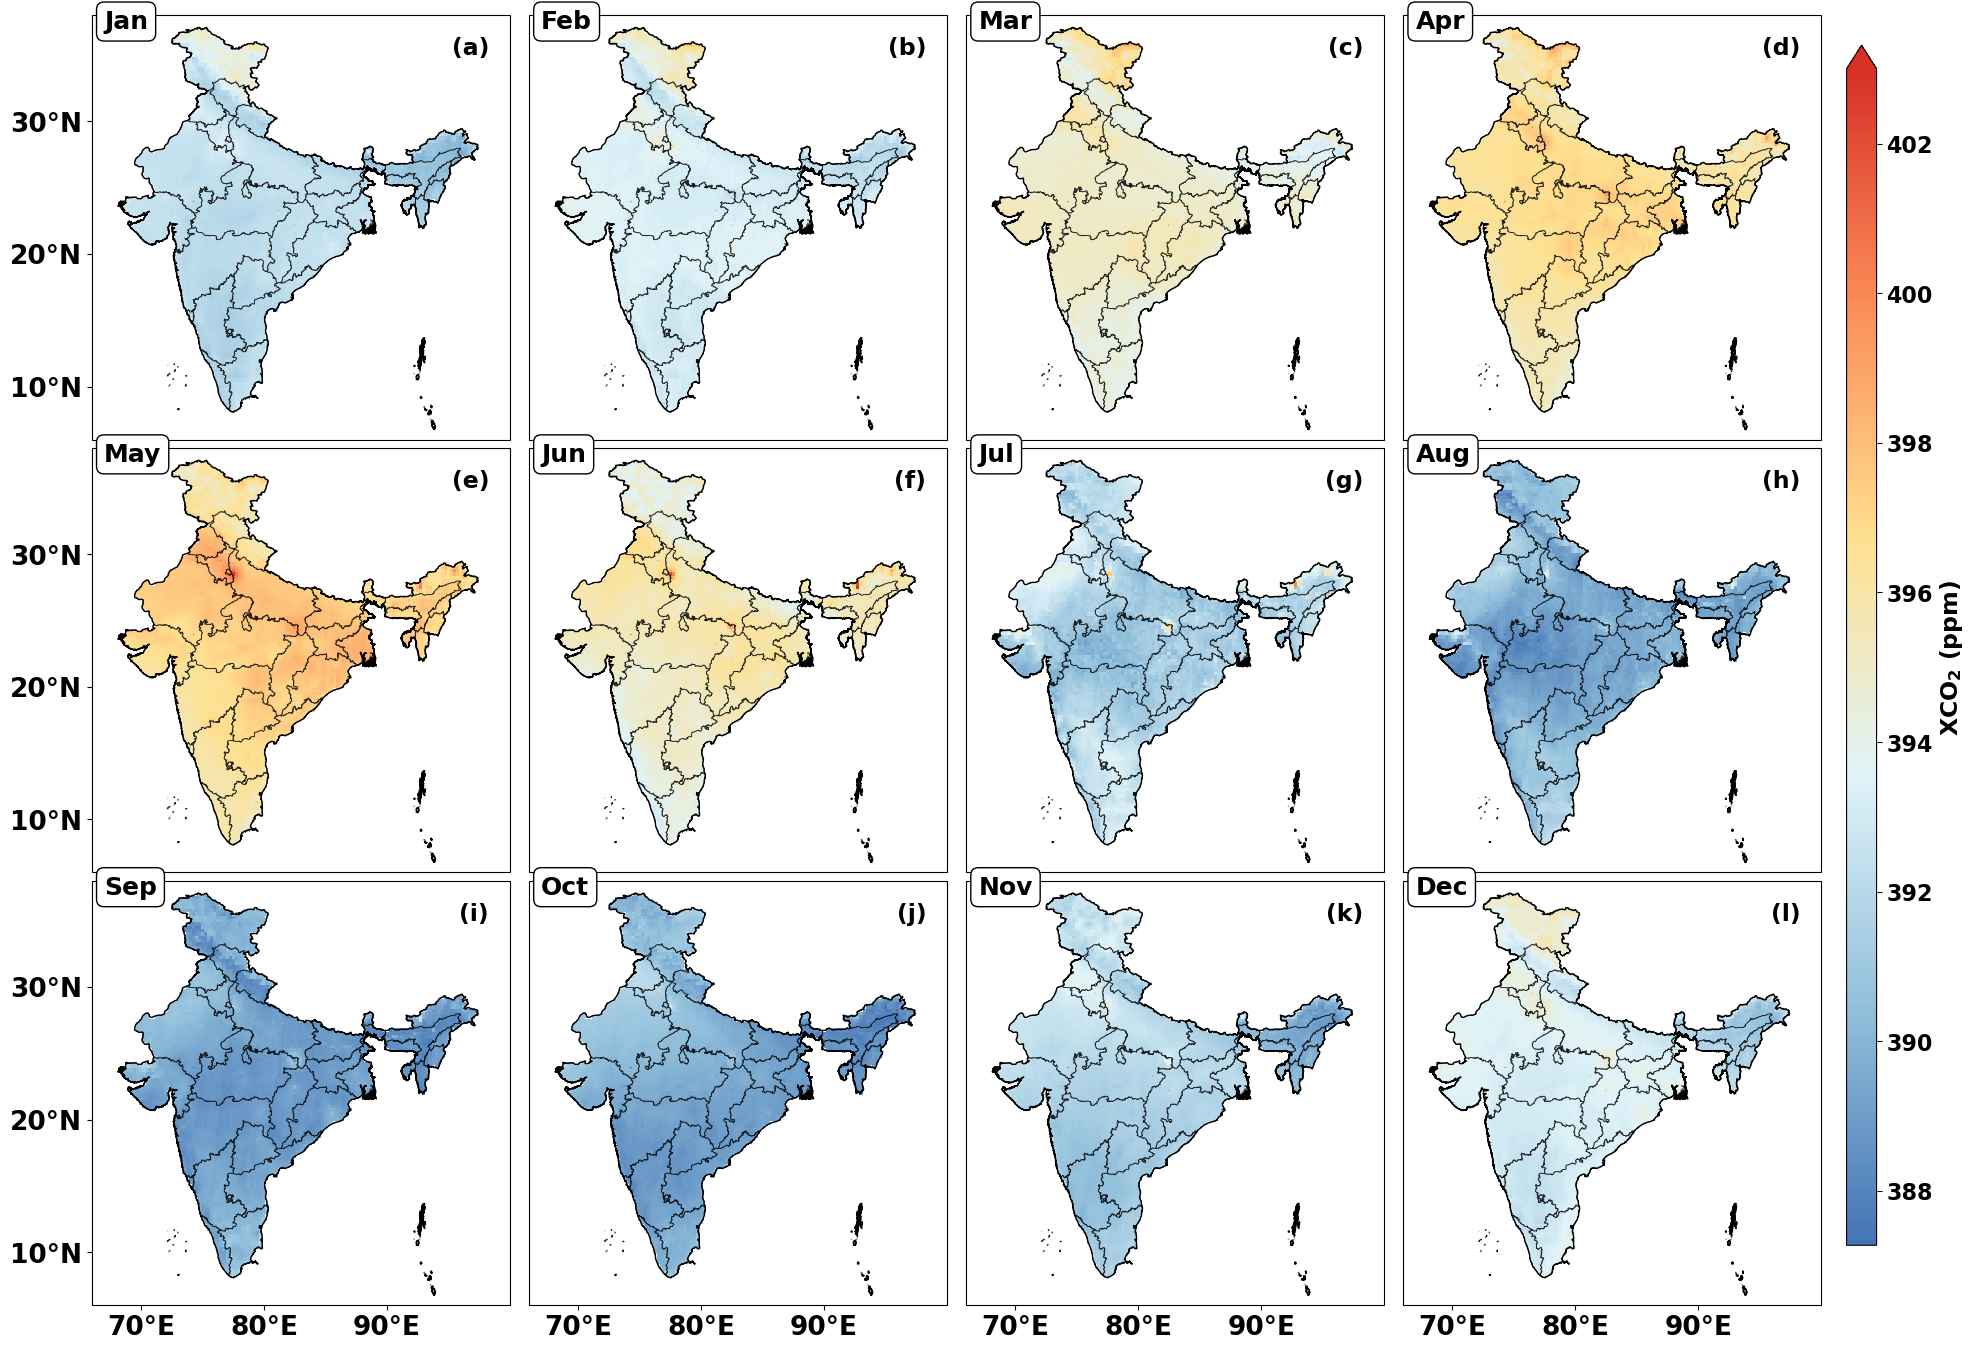

In [13]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


india_shapefile = r'C:\Users\digvi\India_Boundary.shp'
india_boundary = gpd.read_file(india_shapefile).to_crs(epsg=4326)
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'

district_shapefile = r"D:\project_revived_march_25\india_state\Indian_States.shp"  # Update with correct path
district_boundaries = gpd.read_file(district_shapefile)

if district_boundaries.crs is None:
    
    district_boundaries = district_boundaries.set_crs(epsg=4326)  

district_boundaries = district_boundaries.to_crs(epsg=4326)

ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")

ds1 = ds1.assign_coords(month=ds1["time"].dt.month)

monthly_avg_xco2 = ds1["predicted_xco2"].groupby("month").mean(dim="time")

lat_values = ds1.latitude.values
lon_values = ds1.longitude.values


lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

points = [Point(lon, lat) for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())]
geo_df = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

geo_df = gpd.sjoin(geo_df, india_boundary, how="inner", predicate="within")

inside_points = set(geo_df.geometry.apply(lambda p: (p.x, p.y)))
mask = np.array([(lon, lat) in inside_points for lon, lat in zip(lon_mesh.ravel(), lat_mesh.ravel())])
mask = mask.reshape(lat_mesh.shape)

print(f"Mask contains {np.sum(mask)} valid points inside India and {np.sum(~mask)} outside.")

vmin = np.nanmin(monthly_avg_xco2.values)
vmax = min(np.nanmax(monthly_avg_xco2.values), 403)

if vmin == vmax:
    vmax += 1

print(f"Min XCO2: {vmin:.2f}, Max XCO2: {vmax:.2f}")

fig, axes = plt.subplots(3, 4, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, ax in enumerate(axes.flat):
    month_data = monthly_avg_xco2.sel(month=i+1).values
    month_data_masked = np.where(mask, month_data, np.nan)
    
    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())

        
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

    
    clipped_districts = gpd.clip(district_boundaries, india_boundary)
    clipped_districts.boundary.plot(ax=ax, edgecolor='black', linewidth=0.6, alpha=0.6)


    im = ax.pcolormesh(lon_mesh, lat_mesh, month_data_masked, cmap=custom_cmap, vmin=vmin, vmax=vmax)

    ax.text(67, 37, month_names[i], fontsize=18, fontweight='bold', color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    if i % 4 == 0:
        yticks = np.arange(10, 37, 10)
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.set_yticklabels([f"{y}°N" for y in yticks], fontsize=19, fontweight='bold')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    
    if i >= 8:
        xticks = np.arange(70, 97, 10)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_xticklabels([f"{x}°E" for x in xticks], fontsize=19, fontweight='bold')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

import matplotlib.pyplot as plt
import string

labels = list(string.ascii_lowercase[:12])  

for i in range(3):
    for j in range(4):
        label_index = i * 4 + j
        axes[i, j].text(0.95, 0.95, f'({labels[label_index]})',
                        transform=axes[i, j].transAxes,
                        fontsize=17, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(left=0.03, right=0.9, top=0.92, bottom=0.06, wspace=0.02, hspace=0.02)

cbar_ax = fig.add_axes([0.91, 0.1, 0.015, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax , extend='max', extendfrac = 0.02)
cbar.set_label(f"X{format_co2_label()} (ppm)", fontsize=17, fontweight='bold', color='black')
cbar.ax.tick_params(labelsize=16, labelcolor='black')
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

#plt.savefig(r"D:\Results_custom_map\200ep2ndFeb_Monthly_mean_XCO2_ML_2003_2020.png", dpi=600, bbox_inches='tight')
plt.show()



--- Growth Rate Statistics (ppm/year) ---
ML XCO2:       Min = 0.6940, Max = 3.7333
CT XCO2:       Min = 1.3407, Max = 3.7414
CAMS XCO2:     Min = 0.4245, Max = 4.2376
Satellite XCO2:Min = 0.4950, Max = 4.0674
NOAA Surface:  Min = 1.1916, Max = 3.6512


C:\Users\digvi\AppData\Local\Temp\ipykernel_12068\3863400091.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontweight="bold", fontsize=12)


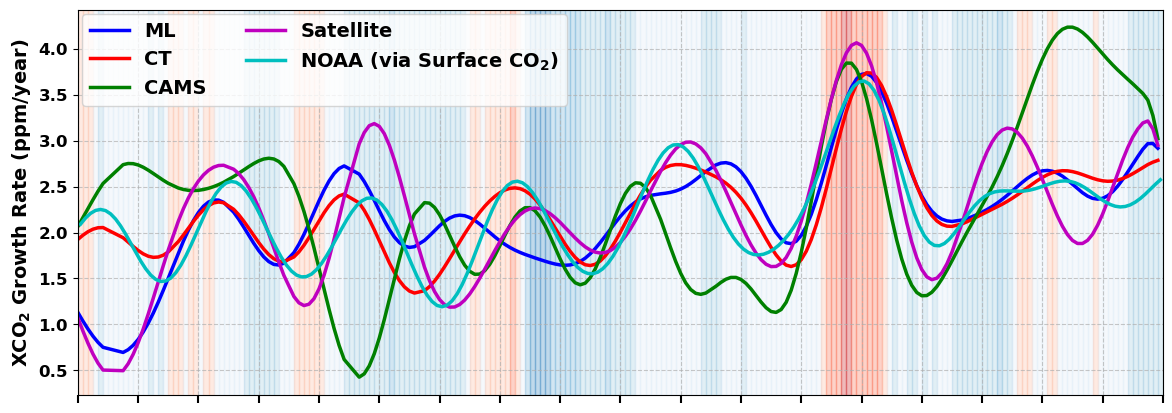

In [14]:
import ccg_filter
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm


ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_landmasked_ML_2003_2020.nc")
ds2 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\CT_data_2003_2020_masked_india_land_xco2.nc")
ds3 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\CAMS_data_2003_2020_masked_india_land_xco2.nc")
ds4 = xr.open_dataset(r"D:\project_revived_march_25\OCO2_new\12thOCT25_landmasked_SAT_xco2_2003_20.nc")

predicted_xco2 = ds1["predicted_xco2"].values
ctco2 = ds2["ctco2"].values
tcco2 = ds3["tcco2"].values
sat_co2 = ds4["xco2_adjusted"].values

def get_decimal_years(ds):
    time_array = pd.to_datetime(ds["time"].values)
    return time_array.year + (time_array.month - 1) / 12

decimal_years1 = get_decimal_years(ds1)
decimal_years2 = get_decimal_years(ds2)
decimal_years3 = get_decimal_years(ds3)
decimal_years4 = get_decimal_years(ds4)

valid_indices = ~np.isnan(sat_co2)

predicted_xco2 = predicted_xco2[valid_indices]
ctco2 = ctco2[valid_indices]
tcco2 = tcco2[valid_indices]
sat_co2 = sat_co2[valid_indices]

decimal_years1 = decimal_years1[valid_indices]
decimal_years2 = decimal_years2[valid_indices]
decimal_years3 = decimal_years3[valid_indices]
decimal_years4 = decimal_years4[valid_indices]
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'  
shortterm = 80
longterm = 667
sampleinterval = 0
numpolyterms = 3
numharmonics = 4
timezero = 0
gap = 0
debug = False

def compute_growth_rate(xp, yp):
    filt = ccg_filter.ccgFilter(xp, yp, shortterm, longterm, sampleinterval, numpolyterms, numharmonics, timezero, gap, debug)
    return filt.getGrowthRateValue(xp)

gr_ml = compute_growth_rate(decimal_years1, predicted_xco2)
gr_ct = compute_growth_rate(decimal_years2, ctco2)
gr_cams = compute_growth_rate(decimal_years3, tcco2)
gr_sat = compute_growth_rate(decimal_years4, sat_co2)

df = pd.read_csv(r"D:\all_years_xco2\NOAA_co2_mm_gl_clean.csv")
df = df[(df["decimal"] >= 2003) & (df["decimal"] <= 2021)]
gr_avg = compute_growth_rate(df["decimal"].values, df["average"].values)

enso_df = pd.read_csv(r"D:\all_years_xco2\cleaned_output.csv")

enso_monthly = []
for _, row in enso_df.iterrows():
    year = int(row["Year"])
    for month in range(1, 13):
        decimal_year = year + (month - 1) / 12
        enso_monthly.append([decimal_year, row.iloc[month]])

enso_monthly_df = pd.DataFrame(enso_monthly, columns=["decimal_year", "enso_index"])
enso_monthly_df = enso_monthly_df[(enso_monthly_df["decimal_year"] >= 2003) & (enso_monthly_df["decimal_year"] <= 2021)]

colors = [
    '#3182bd',  
    '#6baed6',  
    '#9ecae1',  
    '#deebf7', 
    '#fcbba1',  
    '#fb6a4a',  
    '#cb181d'   
]
cmap = ListedColormap(colors)

levels = np.linspace(-3, 3, 8)  # [-3, -2, -1, 0, 1, 2, 3]
norm = BoundaryNorm(levels, ncolors=cmap.N)

fig, ax = plt.subplots(figsize=(14, 5))

enso_values = enso_monthly_df["enso_index"].values


for decimal_year, value in enso_monthly_df.itertuples(index=False):
    color = cmap(norm(value))
    ax.axvspan(decimal_year, decimal_year + (1 / 12), color=color, alpha=0.3)

ax.plot(decimal_years1, gr_ml, 'b-', label= f"ML", linewidth=2.5)
ax.plot(decimal_years2, gr_ct, 'r-', label= f"CT", linewidth=2.5)
ax.plot(decimal_years3, gr_cams, 'g-', label= f"CAMS", linewidth=2.5)
ax.plot(decimal_years4, gr_sat, 'm-', label= f"Satellite", linewidth=2.5)
ax.plot(df["decimal"].values, gr_avg, 'c-', label= f"NOAA (via Surface {format_co2_label()})", linewidth=2.5)
print("\n--- Growth Rate Statistics (ppm/year) ---")
print(f"ML XCO2:       Min = {np.nanmin(gr_ml):.4f}, Max = {np.nanmax(gr_ml):.4f}")
print(f"CT XCO2:       Min = {np.nanmin(gr_ct):.4f}, Max = {np.nanmax(gr_ct):.4f}")
print(f"CAMS XCO2:     Min = {np.nanmin(gr_cams):.4f}, Max = {np.nanmax(gr_cams):.4f}")
print(f"Satellite XCO2:Min = {np.nanmin(gr_sat):.4f}, Max = {np.nanmax(gr_sat):.4f}")
print(f"NOAA Surface:  Min = {np.nanmin(gr_avg):.4f}, Max = {np.nanmax(gr_avg):.4f}")

ax.set_ylabel(f"X{format_co2_label()} Growth Rate (ppm/year)", fontsize=14, fontweight='bold', color='black')
ax.set_xticks(np.arange(2003, 2022, 1))
ax.set_xticklabels(np.arange(2003, 2022, 1), fontsize=12, fontweight='bold', color='black')

ax.tick_params(axis='y', labelsize=12)
ax.set_yticklabels(ax.get_yticks(), fontweight="bold", fontsize=12)

legend = ax.legend(
    fontsize=14,
    loc="upper left",
    ncol=2,
    frameon=True,
    bbox_to_anchor=(-0.005, 1.015)  
)

for text in legend.get_texts():
    text.set_color("black")  
    text.set_weight("bold")

ax.grid(True, linestyle="--", alpha=0.7)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for label in cbar.ax.get_xticklabels():
    label.set_fontweight("bold")
    label.set_color("black")

ax.set_xlim(2003, 2021)
ax.set_xticks(np.arange(2003, 2022, 1))       
ax.set_xticklabels([])                        
ax.tick_params(axis='x', length=6, width=1.5, color='black')  

#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_GrowthRates_ENSO_2003_2020.png", dpi=600, bbox_inches='tight')
plt.show()


ML AMGR: min = 1.2806, max = 3.4352
CT AMGR: min = 1.7147, max = 3.4057
CAMS AMGR: min = 0.9860, max = 3.7761
Satellite AMGR: min = 0.3346, max = 3.6853
NOAA AMGR: min = 1.4758, max = 3.4167


C:\Users\digvi\AppData\Local\Temp\ipykernel_12068\2207499879.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontweight="bold", fontsize=12)


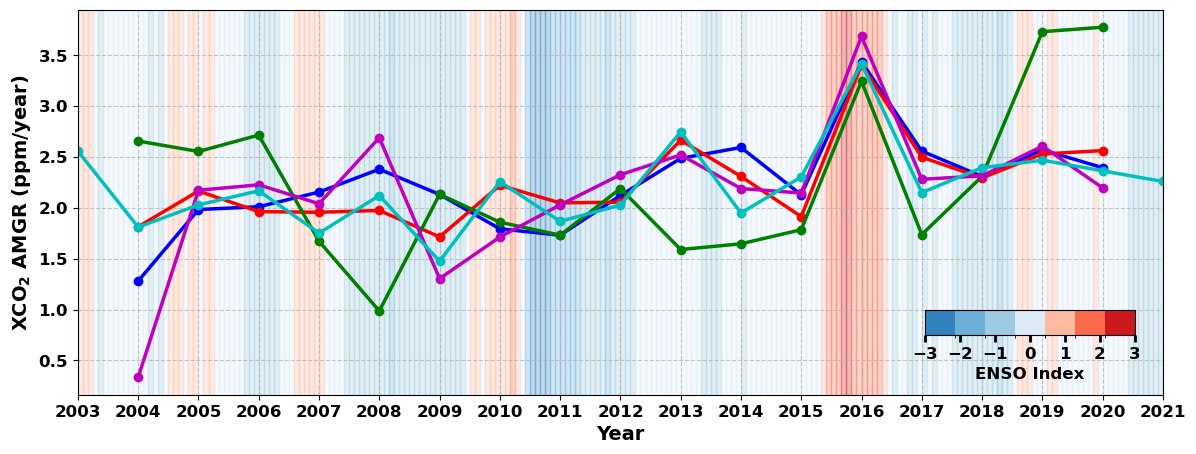

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm


ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_pred_xco2_with_ann_inc.nc")
ds2 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\new_ct_xco2_dataset_with_ann_inc.nc")
ds3 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\new_cams_xco2_dataset_with_ann_inc.nc")
ds4 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_sat_xco2_with_ann_inc.nc")

years = ds1["year"].values  

amgr_ml = ds1["pred_ann_inc"].values
amgr_ct = ds2["ct_ann_inc"].values
amgr_cams = ds3["cams_ann_inc"].values
amgr_sat = ds4["sat_ann_inc"].values

# NOAA Data
df_noaa = pd.read_csv(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\noaa_annual_increase_average.csv")
df_noaa = df_noaa[(df_noaa["year"] >= 2003) & (df_noaa["year"] <= 2021)]
years_noaa_final = df_noaa["year"].values
amgr_noaa_final = df_noaa["ann_inc"].values

print(f"ML AMGR: min = {np.nanmin(amgr_ml):.4f}, max = {np.nanmax(amgr_ml):.4f}")
print(f"CT AMGR: min = {np.nanmin(amgr_ct):.4f}, max = {np.nanmax(amgr_ct):.4f}")
print(f"CAMS AMGR: min = {np.nanmin(amgr_cams):.4f}, max = {np.nanmax(amgr_cams):.4f}")
print(f"Satellite AMGR: min = {np.nanmin(amgr_sat):.4f}, max = {np.nanmax(amgr_sat):.4f}")
print(f"NOAA AMGR: min = {np.nanmin(amgr_noaa_final):.4f}, max = {np.nanmax(amgr_noaa_final):.4f}")

# ENSO Data
enso_df = pd.read_csv(r"D:\all_years_xco2\cleaned_output.csv")
enso_monthly = []
for _, row in enso_df.iterrows():
    year = int(row["Year"])
    for month in range(1, 13):
        decimal_year = year + (month - 1) / 12
        enso_monthly.append([decimal_year, row.iloc[month]])
enso_monthly_df = pd.DataFrame(enso_monthly, columns=["decimal_year", "enso_index"])
enso_monthly_df = enso_monthly_df[(enso_monthly_df["decimal_year"] >= 2003) & (enso_monthly_df["decimal_year"] <= 2021)]

colors = [
    '#3182bd',  
    '#6baed6',  
    '#9ecae1',  
    '#deebf7',  
    '#fcbba1',  
    '#fb6a4a', 
    '#cb181d'   
]
cmap = ListedColormap(colors)

levels = np.linspace(-3, 3, 8)  
norm = BoundaryNorm(levels, ncolors=cmap.N)

fig, ax = plt.subplots(figsize=(14, 5))

enso_values = enso_monthly_df["enso_index"].values

for decimal_year, value in enso_monthly_df.itertuples(index=False):
    color = cmap(norm(value))
    ax.axvspan(decimal_year, decimal_year + 1/12, color=color, alpha=0.3)

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'

ax.plot(years, amgr_ml, 'b-o', label="ML", linewidth=2.5)
ax.plot(years, amgr_ct, 'r-o', label="CT", linewidth=2.5)
ax.plot(years, amgr_cams, 'g-o', label="CAMS", linewidth=2.5)
ax.plot(years, amgr_sat, 'm-o', label="Satellite", linewidth=2.5)
ax.plot(years_noaa_final, amgr_noaa_final, 'c-o', label=f"NOAA (via Surface {format_co2_label()})", linewidth=2.5)

# Axis & labels
ax.set_xlabel("Year", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel(f"X{format_co2_label()} AMGR (ppm/year)", fontsize=14, fontweight='bold', color='black')
ax.set_xticks(np.arange(2003, 2022))
ax.set_xlim(2003, 2021)
ax.set_xticklabels(np.arange(2003, 2022), fontsize=12, fontweight='bold', color='black')
ax.tick_params(axis='y', labelsize=12)
ax.set_yticklabels(ax.get_yticks(), fontweight="bold", fontsize=12)


ax.grid(True, linestyle="--", alpha=0.7)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.73, 0.23, 0.15, 0.05])  
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=np.arange(-3, 4, 1))
cbar.set_label("ENSO Index", fontsize=12, fontweight="bold", color="black")
cbar.ax.tick_params(labelsize=12, width=2, length=5, color="black", labelcolor="black")
for label in cbar.ax.get_xticklabels():
    label.set_fontweight("bold")
    label.set_color("black")

#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\200ep15thOCT_AMGR_XCO2_ENSO_2003_2020.png", dpi=600, bbox_inches='tight')
plt.show()


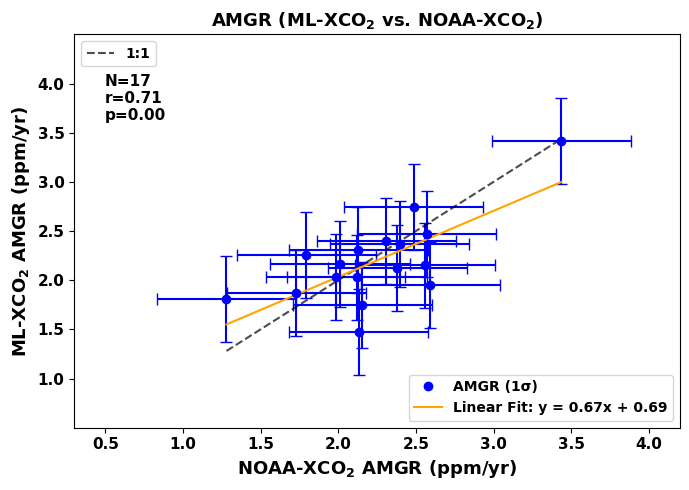

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 
import xarray as xr
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_sat_xco2_with_ann_inc.nc")
ds2 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_pred_xco2_with_ann_inc.nc")
import pandas as pd
df = pd.read_csv(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\noaa_annual_increase_average.csv")

ds2_sel = ds2.sel(year=slice(2004, 2020))
df_filtered = df[(df['year'] >= 2004) & (df['year'] <= 2020)]


pred = ds2_sel['pred_ann_inc'].values
sat = df_filtered['ann_inc'].values


pred_std = ds2_sel['pred_ann_inc'].std(dim='year').values
sat_std = df_filtered.groupby('year')['ann_inc'].mean().std()



slope, intercept, r_value, p_value, std_err = stats.linregress(pred, sat)

x_fit = np.linspace(min(pred), max(pred), 100)
y_fit = slope * x_fit + intercept


plt.figure(figsize=(7, 5))

plt.errorbar(
    pred, sat,
    xerr=pred_std, yerr=sat_std,
    fmt='o', color='blue', ecolor='blue', capsize=4,
    label='AMGR (1σ)'
)

line1to1, = plt.plot(x_fit, x_fit, 'k--', alpha=0.7, label='1:1')

reg_line, = plt.plot(x_fit, y_fit, color='orange',
                     label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}')

plt.text(
    0.05, 0.90, f'N={len(sat)}\nr={r_value:.2f}\np={p_value:.2f}',
    transform=plt.gca().transAxes,
    fontsize=11, weight='bold', color='black',
    verticalalignment='top'

)

plt.xlabel(f'NOAA-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.ylabel(f'ML-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.title(f'AMGR (ML-X{format_co2_label()} vs. NOAA-X{format_co2_label()})',
          fontsize=13, weight='bold', color='black')

plt.xticks(fontsize=11, weight='bold', color='black')

plt.xlim(0.3, 4.2)  
plt.xticks(np.arange(0.5, 4.5, 0.5), fontsize=11, weight='bold', color='black')
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4],
           fontsize=11, weight='bold', color='black')

plt.ylim(0.5, 4.5)

legend1 = plt.legend([line1to1], ['1:1'], loc='upper left',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
legend2 = plt.legend([plt.Line2D([], [], color='blue', marker='o', linestyle=''),
                      reg_line],
                     ['AMGR (1σ)', f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}'],
                     loc='lower right',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
plt.gca().add_artist(legend1)

plt.tight_layout()
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_ML_AMGR_vs_NOAA_AMGR.png", dpi=600, bbox_inches='tight')
plt.show()


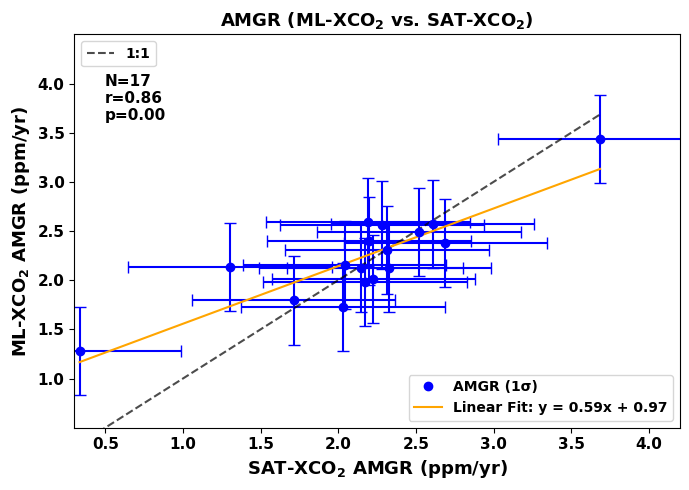

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_sat_xco2_with_ann_inc.nc")
ds2 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_pred_xco2_with_ann_inc.nc")

def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

ds1_sel = ds1.sel(year=slice(2004, 2020))
ds2_sel = ds2.sel(year=slice(2004, 2020))

pred = ds1_sel['sat_ann_inc'].values
sat = ds2_sel['pred_ann_inc'].values

pred_std = ds1_sel['sat_ann_inc'].std(dim='year').values
sat_std = ds2_sel['pred_ann_inc'].std(dim='year').values



slope, intercept, r_value, p_value, std_err = stats.linregress(pred, sat)

x_fit = np.linspace(min(pred), max(pred), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(7, 5))

plt.errorbar(
    pred, sat,
    xerr=pred_std, yerr=sat_std,
    fmt='o', color='blue', ecolor='blue', capsize=4,
    label='AMGR (1σ)'
)

line1to1, = plt.plot(x_fit, x_fit, 'k--', alpha=0.7, label='1:1')

reg_line, = plt.plot(x_fit, y_fit, color='orange',
                     label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}')

plt.text(
    0.05, 0.90, f'N={len(sat)}\nr={r_value:.2f}\np={p_value:.2f}',
    transform=plt.gca().transAxes,
    fontsize=11, weight='bold', color='black',
    verticalalignment='top'
    
)

plt.xlabel(f'SAT-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.ylabel(f'ML-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.title(f'AMGR (ML-X{format_co2_label()} vs. SAT-X{format_co2_label()})',
          fontsize=13, weight='bold', color='black')

plt.xticks(fontsize=11, weight='bold', color='black')

plt.xlim(0.3, 4.2)  
plt.xticks(np.arange(0.5, 4.5, 0.5), fontsize=11, weight='bold', color='black')
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4],
           fontsize=11, weight='bold', color='black')

plt.ylim(0.5, 4.5)

legend1 = plt.legend([line1to1], ['1:1'], loc='upper left',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
legend2 = plt.legend([plt.Line2D([], [], color='blue', marker='o', linestyle=''),
                      reg_line],
                     ['AMGR (1σ)', f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}'],
                     loc='lower right',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
plt.gca().add_artist(legend1)

plt.tight_layout()
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_ML_AMGR_vs_NOAA_AMGR.png", dpi=600, bbox_inches='tight')
plt.show()


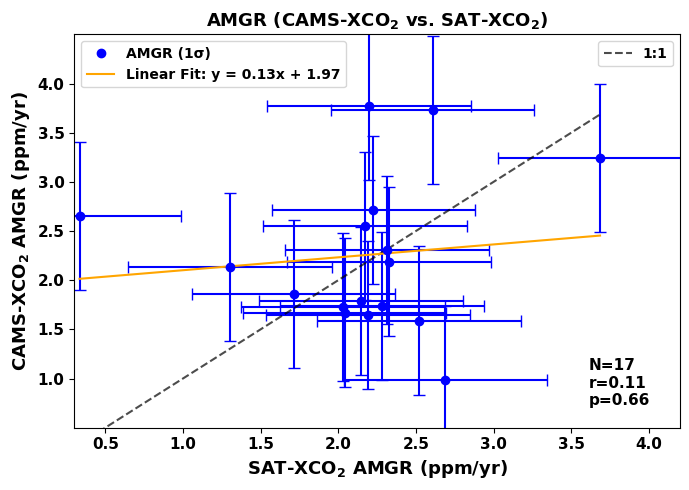

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_sat_xco2_with_ann_inc.nc")
ds2 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\new_cams_xco2_dataset_with_ann_inc.nc")
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 


ds1_sel = ds1.sel(year=slice(2004, 2020))
ds2_sel = ds2.sel(year=slice(2004, 2020))

pred = ds1_sel['sat_ann_inc'].values
sat = ds2_sel['cams_ann_inc'].values

pred_std = ds1_sel['sat_ann_inc'].std(dim='year').values
sat_std = ds2_sel['cams_ann_inc'].std(dim='year').values



slope, intercept, r_value, p_value, std_err = stats.linregress(pred, sat)

x_fit = np.linspace(min(pred), max(pred), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(7, 5))

plt.errorbar(
    pred, sat,
    xerr=pred_std, yerr=sat_std,
    fmt='o', color='blue', ecolor='blue', capsize=4,
    label='AMGR (1σ)'
)

line1to1, = plt.plot(x_fit, x_fit, 'k--', alpha=0.7, label='1:1')

reg_line, = plt.plot(x_fit, y_fit, color='orange',
                     label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}')

plt.text(
    0.85, 0.05, f'N={len(sat)}\nr={r_value:.2f}\np={p_value:.2f}',
    transform=plt.gca().transAxes,
    fontsize=11, weight='bold', color='black',
    verticalalignment='bottom'
    
)

plt.xlabel(f'SAT-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.ylabel(f'CAMS-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.title(f'AMGR (CAMS-X{format_co2_label()} vs. SAT-X{format_co2_label()})',
          fontsize=13, weight='bold', color='black')

plt.xticks(fontsize=11, weight='bold', color='black')

plt.xlim(0.3, 4.2)   
plt.xticks(np.arange(0.5, 4.5, 0.5), fontsize=11, weight='bold', color='black')
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4],
           fontsize=11, weight='bold', color='black')

plt.ylim(0.5, 4.5)

legend1 = plt.legend([line1to1], ['1:1'], loc='upper right',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
legend2 = plt.legend([plt.Line2D([], [], color='blue', marker='o', linestyle=''),
                      reg_line],
                     ['AMGR (1σ)', f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}'],
                     loc='upper left',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
plt.gca().add_artist(legend1)

plt.tight_layout()
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\200ep15thOCT_CAMS_AMGR_vs_SAT_AMGR.png", dpi=600, bbox_inches='tight')
plt.show()


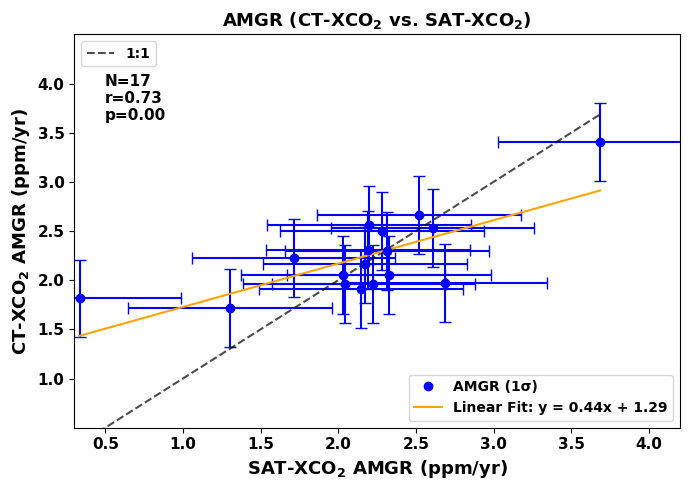

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep15thOCT_sat_xco2_with_ann_inc.nc")
ds2 = xr.open_dataset(r"C:\Users\digvi\project_revived\models_develop\ccg_filter_growth_rate_plot\new_ct_xco2_dataset_with_ann_inc.nc")
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$' 

ds1_sel = ds1.sel(year=slice(2004, 2020))
ds2_sel = ds2.sel(year=slice(2004, 2020))

pred = ds1_sel['sat_ann_inc'].values
sat = ds2_sel['ct_ann_inc'].values

pred_std = ds1_sel['sat_ann_inc'].std(dim='year').values
sat_std = ds2_sel['ct_ann_inc'].std(dim='year').values

slope, intercept, r_value, p_value, std_err = stats.linregress(pred, sat)

x_fit = np.linspace(min(pred), max(pred), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(7, 5))

plt.errorbar(
    pred, sat,
    xerr=pred_std, yerr=sat_std,
    fmt='o', color='blue', ecolor='blue', capsize=4,
    label='AMGR (1σ)'
)

line1to1, = plt.plot(x_fit, x_fit, 'k--', alpha=0.7, label='1:1')

reg_line, = plt.plot(x_fit, y_fit, color='orange',
                     label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}')

plt.text(
    0.05, 0.90, f'N={len(sat)}\nr={r_value:.2f}\np={p_value:.2f}',
    transform=plt.gca().transAxes,
    fontsize=11, weight='bold', color='black',
    verticalalignment='top'
    
)

plt.xlabel(f'SAT-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.ylabel(f'CT-X{format_co2_label()} AMGR (ppm/yr)', fontsize=13, weight='bold', color='black')
plt.title(f'AMGR (CT-X{format_co2_label()} vs. SAT-X{format_co2_label()})',
          fontsize=13, weight='bold', color='black')

plt.xticks(fontsize=11, weight='bold', color='black')

plt.xlim(0.3, 4.2)  
plt.xticks(np.arange(0.5, 4.5, 0.5), fontsize=11, weight='bold', color='black')
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4],
           fontsize=11, weight='bold', color='black')

plt.ylim(0.5, 4.5)

legend1 = plt.legend([line1to1], ['1:1'], loc='upper left',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
legend2 = plt.legend([plt.Line2D([], [], color='blue', marker='o', linestyle=''),
                      reg_line],
                     ['AMGR (1σ)', f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}'],
                     loc='lower right',
                     labelcolor='black', fontsize=12, frameon=True, prop={'weight': 'bold'})
plt.gca().add_artist(legend1)

plt.tight_layout()
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_ML_AMGR_vs_NOAA_AMGR.png", dpi=600, bbox_inches='tight')
plt.show()


C:\Users\digvi\AppData\Local\Temp\ipykernel_12068\2482114433.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


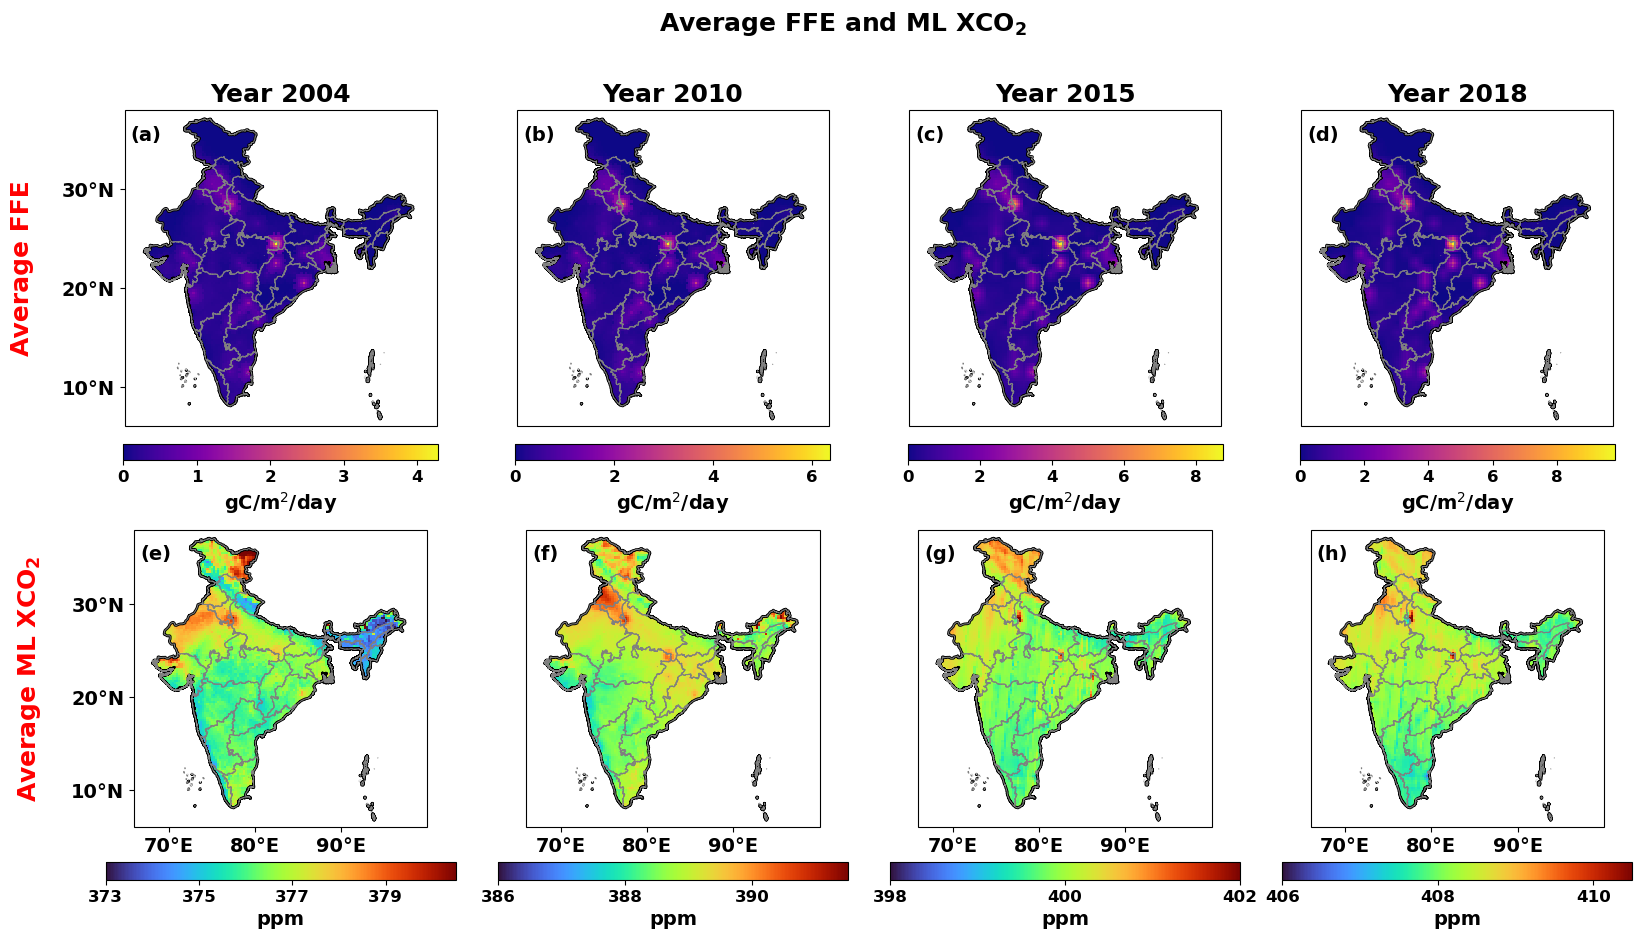

In [20]:
import xarray as xr
ds1 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.nc")
ds2 = xr.open_dataset(r"D:\12thApr_proj_desktop\odiac_2003_12_merged.nc")
ds3 =xr.open_dataset(r"D:\project_work\DNN modelProject\fossilfuel&cement_emission_co2\New folder\merged_regridded_data.nc")
ds4 = xr.open_dataset(r"D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.nc")


import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
def format_co2_label():
    return 'CO' + r'$\mathbf{_{2}}$'
def clip_data_to_boundary(lon, lat, var_avg, shapefile):
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    points = [Point(lon_mesh.flatten()[i], lat_mesh.flatten()[i]) for i in range(lon_mesh.size)]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    boundary_mask = points_gdf.sjoin(shapefile, how="inner", predicate="within")
    mask = np.zeros(var_avg.shape, dtype=np.uint8).flatten()
    mask[boundary_mask.index] = 1
    mask = mask.reshape(var_avg.shape)
    masked_data = np.where(mask == 1, var_avg, np.nan)
    return masked_data

def preprocess_data(ds, var_name, time_range, shapefile):
    ds = ds.sel(time=slice(time_range[0], time_range[1]))
    var_avg = ds[var_name].mean(dim="time")
    if 'lat' in ds.coords and 'lon' in ds.coords:
        ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
    lat = np.array(ds['latitude'])
    lon = np.array(ds['longitude'])
    if lat[0] > lat[-1]:
        lat = lat[::-1]
        var_avg = var_avg[::-1, :]
    masked_data = clip_data_to_boundary(lon, lat, np.array(var_avg), shapefile)
    return masked_data, lon, lat


india_boundary = gpd.read_file(r'C:\Users\digvi\India_Boundary.shp')

# Define time ranges
time_range_2004 = ("2004-01-01", "2004-12-31")
time_range_2010 = ("2010-01-01", "2010-12-31")
time_range_2015 = ("2015-01-01", "2015-12-31")
time_range_2018 = ("2018-01-01", "2018-12-31")


xco2_2004, lon_xco2, lat_xco2 = preprocess_data(ds1, "predicted_xco2", time_range_2004, india_boundary)
xco2_2010, _, _ = preprocess_data(ds1, "predicted_xco2", time_range_2010, india_boundary)
xco2_2015, _, _ = preprocess_data(ds1, "predicted_xco2", time_range_2015, india_boundary)
xco2_2018, _, _ = preprocess_data(ds4, "predicted_xco2", time_range_2018, india_boundary)

ffe_2010, lon_ffe, lat_ffe = preprocess_data(ds2, "land", time_range_2010, india_boundary)

ffe_2004, _, _ = preprocess_data(ds2, "land", time_range_2004, india_boundary)
ffe_2010, _, _ = preprocess_data(ds2, "land", time_range_2010, india_boundary)
ffe_2015, _, _ = preprocess_data(ds3, "land", time_range_2015, india_boundary)
ffe_2018, _, _ = preprocess_data(ds3, "land", time_range_2018, india_boundary)
# Plotting
fig, axes = plt.subplots(
    2, 4, figsize=(20, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.05, 'hspace': 0.2}
)

data_list = [ffe_2004, ffe_2010, ffe_2015, ffe_2018, xco2_2004, xco2_2010, xco2_2015, xco2_2018, None]
units = ["gC/m$^2$/day"] * 4 + ["ppm"] * 4 + [""]
cmap_list = ["plasma"] * 4 + ["turbo"] * 4 + [""]

from matplotlib.ticker import MultipleLocator
india_states = gpd.read_file(r"D:\project_revived_march_25\india_state\Indian_States.shp").to_crs(epsg=4326)

for i, ax in enumerate(axes.flat):
    if data_list[i] is None:
        ax.axis("off")
        continue

    ax.set_extent([66, 100, 6, 38], crs=ccrs.PlateCarree())
    india_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
    india_states.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.7)

    if i <= 3:
        lon_grid, lat_grid = np.meshgrid(lon_ffe, lat_ffe)
    else:
        lon_grid, lat_grid = np.meshgrid(lon_xco2, lat_xco2)

    im = ax.pcolormesh(
        lon_grid, lat_grid, data_list[i],
        cmap=cmap_list[i], shading="auto"
    )

    ax.set_xticks(np.arange(66, 101, 5))
    ax.set_yticks(np.arange(6, 39, 5))
    ax.tick_params(axis='both', labelsize=12, labelcolor='black')

    if i % 4 == 0:
        yticks = np.arange(10, 37, 10)
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.set_yticklabels([f"{y}°N" for y in yticks], fontsize=14, fontweight='bold')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    if i >= 4:
        xticks = np.arange(70, 97, 10)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_xticklabels([f"{x}°E" for x in xticks], fontsize=14, fontweight='bold')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    
    if i <= 3:
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.045, pad=0.05)
    else:
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)

    if i == 4:
        vmin, vmax = 373, 380.5
        im.set_clim(vmin, vmax)
        ticks = np.arange(vmin, vmax + 0.1, 2)
        cbar.set_ticks(ticks)


    if i == 5:
        vmin, vmax = 386, 391.5
        im.set_clim(vmin, vmax)
        ticks = np.arange(vmin, vmax + 0.1, 2)
        cbar.set_ticks(ticks)

    if i == 6:
        vmin, vmax = 398, 402
        im.set_clim(vmin, vmax)
        ticks = np.arange(vmin, vmax + 0.1, 2)
        cbar.set_ticks(ticks)

    if i == 7:
        vmin, vmax = 406, 410.5
        im.set_clim(vmin, vmax)
        ticks = np.arange(vmin, vmax + 0.1, 2)
        cbar.set_ticks(ticks)


    cbar.set_label(f"{units[i]}", fontsize=14, fontweight='bold', color='black')
    cbar.ax.tick_params(labelsize=12, labelcolor='black')
    for label in cbar.ax.get_xticklabels():
        label.set_fontweight('bold')
        label.set_color('black')

row_titles = ['Average FFE', f'Average ML X{format_co2_label()}']

column_titles = ['Year 2004', 'Year 2010', 'Year 2015', 'Year 2018']

for i in range(2):
    for j in range(4):
        
        if j == 0:  
            axes[i, j].set_ylabel(row_titles[i], fontsize=18, fontweight='bold', color='red', labelpad=20)

        
        if i == 0:  
            axes[i, j].set_title(column_titles[j], fontsize=18, fontweight='bold', color='black')

import string

labels = list(string.ascii_lowercase[:8])  

for i in range(2):
    for j in range(4):
        label_index = i * 4 + j
        axes[i, j].text(0.02, 0.95, f'({labels[label_index]})',
                        transform=axes[i, j].transAxes,
                        fontsize=14, fontweight='bold', va='top', ha='left')

fig.suptitle(f"Average FFE and ML X{format_co2_label()} ", fontsize=18, fontweight='bold', color='black')
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig(r"D:\11thOCT25\14thOCT_DNN\200ep_Results\new200ep15thOCT_Average_MLXCO2_FFE.png", dpi=600, bbox_inches='tight')


plt.show()
